In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

# 多クラス分類の例：ニュース配信の分類

分類のクラスを増やす。    
多クラス単一ラベル single-label multiclass classification。多クラス多ラベル分類 multilabel multiclass classification。

## Reutersデータセット

Reutersデータセットを使用。
短いビュース記事とトピックを集めたもの。トピックは46種類。

In [0]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

num_words=10000で絞ってる。

In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

単語インデックスのリスト

In [6]:
train_data[10][:10]

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14]

参考までに単語インデックスを単語に戻す

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 1s 2us/step


In [8]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

サンプルに関連づけられてるのは0〜45のトピックインデックス

In [9]:
train_labels[10]

3

## データの準備

データのベクトル化には前節の例を同じコードを使用。

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

print(x_train.shape)
print(x_test.shape)

(8982, 10000)
(2246, 10000)



ラベルのベクトル化は２つの選択肢がある。    
ラベルのリストを整数のテンソルとしてキャストするか、one-hotエンコーディングを使用するか。    
one-hotはカテゴリエンコーディングとも呼ばれる。    
ラベルのインデックスの位置に１が含まれている以外は全て０で設定されたベクトル



In [11]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

print(one_hot_train_labels.shape)
print(one_hot_test_labels.shape)
print(one_hot_train_labels)
print(one_hot_test_labels)

(8982, 46)
(2246, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


MNISTで使ったto_categoricalは同じことができる。

In [12]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(one_hot_train_labels.shape)
print(one_hot_test_labels.shape)
print(one_hot_train_labels)
print(one_hot_test_labels)

(8982, 46)
(2246, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## ニューラルネットワークの構築


トピック分類問題は、短いテキストの分類という点では映画レビュー分類と似ているように見える。違いは出力クラスの数が2から46に増えてる点。

層がスタックされてる場合は１つ前の情報しか見れないので、どこかの層で分類問題に関する情報が抜け落ちた場合に、その情報をその後の層で復元することは不可能。    

その意味ではどの層も情報のボトルネックになる可能性を秘めている。

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

このアーキテクチャは２つ注意しないといけない    

- ネットワークの最後の層はサイズが64次元    
- 最終層はsoftmax。出力は46種類の出力クラスの確率分布。合計するとほぼ１になる。




In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## アプローチの検証

訓練データのうち1000サンプルを検証データセットとする。


In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

20エポックを使用

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 141us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 0s 57us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 0s 58us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 0s 58us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 0s 60us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 0s 60us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 0s 60us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020
Epoch 

7982/7982 [==============================] - 0s 59us/step - loss: 0.1873 - acc: 0.9508 - val_loss: 0.9027 - val_acc: 0.8130
Epoch 13/20
7982/7982 [==============================] - 0s 62us/step - loss: 0.1703 - acc: 0.9521 - val_loss: 0.9323 - val_acc: 0.8110
Epoch 14/20
7982/7982 [==============================] - 1s 63us/step - loss: 0.1536 - acc: 0.9554 - val_loss: 0.9689 - val_acc: 0.8050
Epoch 15/20
7982/7982 [==============================] - 0s 62us/step - loss: 0.1390 - acc: 0.9560 - val_loss: 0.9686 - val_acc: 0.8150
Epoch 16/20
7982/7982 [==============================] - 0s 59us/step - loss: 0.1313 - acc: 0.9560 - val_loss: 1.0220 - val_acc: 0.8060
Epoch 17/20
7982/7982 [==============================] - 0s 59us/step - loss: 0.1217 - acc: 0.9579 - val_loss: 1.0254 - val_acc: 0.7970
Epoch 18/20
7982/7982 [==============================] - 0s 62us/step - loss: 0.1198 - acc: 0.9582 - val_loss: 1.0430 - val_acc: 0.8060
Epoch 19/20
7982/7982 [==============================] - 0s 

プロット

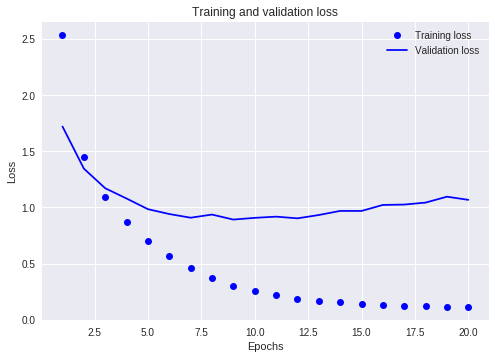

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

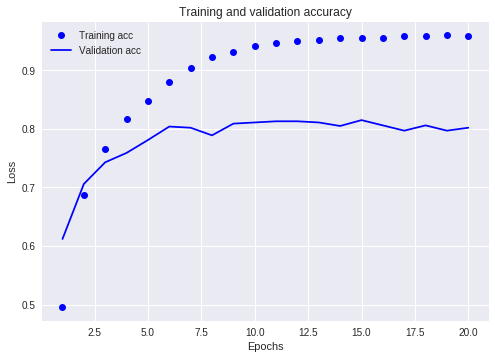

In [18]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

8エポックの後に過学習になってる。

In [19]:

results = model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 128us/step


In [20]:
results

[1.2092603123410939, 0.778717720444884]

正解率は77%付近。ランダムよりはいい精度。

In [21]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1834372217275156

ランダムは低い精度

## 新しいデータで予測値を生成

モデルのpredictは46種類のトピックが全てカバーされた確率分布を返す。これを検証する

In [0]:
predictions = model.predict(x_test)

predictionsの各エントリは46のベクトル

In [23]:
predictions[0].shape

(46,)

ベクトルの係数を合計するとほぼ1になる

In [24]:
np.sum(predictions[0])

1.0000001

最も大きいエントリが予測されたクラス。確率の高いクラス

In [25]:
np.argmax(predictions[0])

3

## ラベルと損失値を処理する別の方法

もう一つのラベルのエンコード方法は、ラベルの整数のテンソルとしてキャストすること


In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

損失関数を変更する。categorical_crossentropyはone-hotである前提なので、整数の場合はsparse_categorical_crossentropyを使用する。

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## 十分な大きさの中間層を持つことの重要性

最終層が46なので中間層で46以下にするのは避けるべき。情報のボトルネックが発生する可能性がある。

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu')) #ここ
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 106us/step - loss: 2.9322 - acc: 0.4530 - val_loss: 2.1616 - val_acc: 0.5910
Epoch 2/20
7982/7982 [==============================] - 1s 90us/step - loss: 1.7658 - acc: 0.6278 - val_loss: 1.6217 - val_acc: 0.6240
Epoch 3/20
7982/7982 [==============================] - 1s 88us/step - loss: 1.4315 - acc: 0.6421 - val_loss: 1.4965 - val_acc: 0.6290
Epoch 4/20
7982/7982 [==============================] - 1s 88us/step - loss: 1.2644 - acc: 0.6537 - val_loss: 1.4162 - val_acc: 0.6390
Epoch 5/20
7982/7982 [==============================] - 1s 87us/step - loss: 1.1321 - acc: 0.7007 - val_loss: 1.3780 - val_acc: 0.6720
Epoch 6/20
7982/7982 [==============================] - 1s 90us/step - loss: 1.0213 - acc: 0.7404 - val_loss: 1.3426 - val_acc: 0.6780
Epoch 7/20
7982/7982 [==============================] - 1s 91us/step - loss: 0.9183 - acc: 0.7720 - val_loss: 1.3076 - val_acc: 0.7050
Epoch 

7982/7982 [==============================] - 1s 93us/step - loss: 0.7302 - acc: 0.8069 - val_loss: 1.3235 - val_acc: 0.7040
Epoch 11/20
7982/7982 [==============================] - 1s 87us/step - loss: 0.6863 - acc: 0.8138 - val_loss: 1.3357 - val_acc: 0.7100
Epoch 12/20
7982/7982 [==============================] - 1s 88us/step - loss: 0.6478 - acc: 0.8193 - val_loss: 1.3792 - val_acc: 0.7130
Epoch 13/20
7982/7982 [==============================] - 1s 88us/step - loss: 0.6105 - acc: 0.8266 - val_loss: 1.3792 - val_acc: 0.7190
Epoch 14/20
7982/7982 [==============================] - 1s 91us/step - loss: 0.5759 - acc: 0.8390 - val_loss: 1.4135 - val_acc: 0.7180
Epoch 15/20
7982/7982 [==============================] - 1s 89us/step - loss: 0.5454 - acc: 0.8498 - val_loss: 1.4353 - val_acc: 0.7210
Epoch 16/20
7982/7982 [==============================] - 1s 91us/step - loss: 0.5160 - acc: 0.8621 - val_loss: 1.4942 - val_acc: 0.7210
Epoch 17/20
7982/7982 [==============================] - 1s 

7982/7982 [==============================] - 1s 95us/step - loss: 0.4261 - acc: 0.8859 - val_loss: 1.5787 - val_acc: 0.7290


検証データの正解率は70%ほど。原因は主に、大量の情報（46のクラスの分離超平面を復元するのに十分な情報）をあまりにも小さな中間層に詰め込もうとしたことにある。    
ネットワークには、これらの４次元表現に必要な情報の「大部分」は詰め込むことができるが、必要な情報が全て詰まってるわけではない。

## その他の実習

- 32ユニットや128ユニットなど、さらに大きい中間層や小さい中間層を試してみる    
- 隠れ層１や３ではどうなるか

# 実験

64 - 2〜50 - 46    
極端に少ないユニットの層によってボトルネックになる様子を観察する

In [33]:
import matplotlib.pyplot as plt

def get_eval(num_unit):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(num_unit, activation='relu')) #ここ
    model.add(layers.Dense(46, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    model.fit(partial_x_train,
              partial_y_train,
              epochs=10,
              batch_size=128,
              validation_data=(x_val, y_val))
    return model.evaluate(x_test, one_hot_test_labels)[1]
eval_list = []
for num_unit in range(2, 50):
    eval_list.append(get_eval(num_unit))
    

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 1s 183us/step - loss: 3.5152 - acc: 0.0588 - val_loss: 3.2434 - val_acc: 0.0570
Epoch 2/10
7982/7982 [==============================] - 1s 88us/step - loss: 2.9399 - acc: 0.2031 - val_loss: 2.7218 - val_acc: 0.2230
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 2.4722 - acc: 0.2215 - val_loss: 2.2388 - val_acc: 0.2370
Epoch 4/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.9544 - acc: 0.3533 - val_loss: 1.8608 - val_acc: 0.5410
Epoch 5/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.6590 - acc: 0.5677 - val_loss: 1.6809 - val_acc: 0.5850
Epoch 6/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.4770 - acc: 0.5942 - val_loss: 1.5984 - val_acc: 0.5870
Epoch 7/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.3716 - acc: 0.6029 - val_loss: 1.5809 - val_acc: 0.6010
Epoch 

2246/2246 [==============================] - 0s 133us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 201us/step - loss: 3.3855 - acc: 0.1006 - val_loss: 3.0592 - val_acc: 0.1370
Epoch 2/10
7982/7982 [==============================] - 1s 89us/step - loss: 2.6088 - acc: 0.2166 - val_loss: 2.2734 - val_acc: 0.4590
Epoch 3/10
7982/7982 [==============================] - 1s 88us/step - loss: 1.8436 - acc: 0.4823 - val_loss: 1.7545 - val_acc: 0.4620
Epoch 4/10
7982/7982 [==============================] - 1s 89us/step - loss: 1.4219 - acc: 0.6090 - val_loss: 1.4816 - val_acc: 0.5960
Epoch 5/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.2356 - acc: 0.6397 - val_loss: 1.4145 - val_acc: 0.6180
Epoch 6/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.1292 - acc: 0.6698 - val_loss: 1.3905 - val_acc: 0.6490
Epoch 7/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.041

7982/7982 [==============================] - 1s 88us/step - loss: 0.9147 - acc: 0.7484 - val_loss: 1.4087 - val_acc: 0.6860
Epoch 10/10
2246/2246 [==============================] - 0s 135us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 202us/step - loss: 3.4084 - acc: 0.1017 - val_loss: 2.9418 - val_acc: 0.2670
Epoch 2/10
7982/7982 [==============================] - 1s 90us/step - loss: 2.3879 - acc: 0.3654 - val_loss: 1.9327 - val_acc: 0.6220
Epoch 3/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.4868 - acc: 0.6723 - val_loss: 1.4449 - val_acc: 0.6640
Epoch 4/10
7982/7982 [==============================] - 1s 89us/step - loss: 1.1808 - acc: 0.7041 - val_loss: 1.3582 - val_acc: 0.6720
Epoch 5/10
7982/7982 [==============================] - 1s 89us/step - loss: 1.0387 - acc: 0.7452 - val_loss: 1.3084 - val_acc: 0.6960
Epoch 6/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.93

7982/7982 [==============================] - 1s 90us/step - loss: 0.7717 - acc: 0.8130 - val_loss: 1.3327 - val_acc: 0.7150
Epoch 9/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.7088 - acc: 0.8222 - val_loss: 1.3584 - val_acc: 0.7260
Epoch 10/10
2246/2246 [==============================] - 0s 136us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 205us/step - loss: 3.0603 - acc: 0.1214 - val_loss: 2.4125 - val_acc: 0.2690
Epoch 2/10
7982/7982 [==============================] - 1s 90us/step - loss: 2.0711 - acc: 0.3419 - val_loss: 1.8608 - val_acc: 0.4190
Epoch 3/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.6992 - acc: 0.4481 - val_loss: 1.6647 - val_acc: 0.4730
Epoch 4/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.4539 - acc: 0.6118 - val_loss: 1.5217 - val_acc: 0.6310
Epoch 5/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.28

7982/7982 [==============================] - 1s 92us/step - loss: 1.0763 - acc: 0.7226 - val_loss: 1.4270 - val_acc: 0.6700
Epoch 8/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.0039 - acc: 0.7547 - val_loss: 1.4263 - val_acc: 0.6890
Epoch 9/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.9410 - acc: 0.7675 - val_loss: 1.4814 - val_acc: 0.6720
Epoch 10/10
2246/2246 [==============================] - 0s 133us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 209us/step - loss: 2.9693 - acc: 0.4352 - val_loss: 2.1226 - val_acc: 0.6140
Epoch 2/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.6694 - acc: 0.6338 - val_loss: 1.4563 - val_acc: 0.6460
Epoch 3/10
7982/7982 [==============================] - 1s 89us/step - loss: 1.2324 - acc: 0.6922 - val_loss: 1.2964 - val_acc: 0.6900
Epoch 4/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.02

7982/7982 [==============================] - 1s 93us/step - loss: 0.7692 - acc: 0.8102 - val_loss: 1.1767 - val_acc: 0.7380
Epoch 7/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.6822 - acc: 0.8296 - val_loss: 1.1898 - val_acc: 0.7400
Epoch 8/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.6101 - acc: 0.8441 - val_loss: 1.2158 - val_acc: 0.7410
Epoch 9/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.5480 - acc: 0.8654 - val_loss: 1.2587 - val_acc: 0.7460
Epoch 10/10
2246/2246 [==============================] - 0s 133us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 212us/step - loss: 2.5204 - acc: 0.4945 - val_loss: 1.7437 - val_acc: 0.6000
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.4418 - acc: 0.6580 - val_loss: 1.3979 - val_acc: 0.6740
Epoch 3/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.13

7982/7982 [==============================] - 1s 91us/step - loss: 0.7653 - acc: 0.8256 - val_loss: 1.1107 - val_acc: 0.7590
Epoch 6/10
7982/7982 [==============================] - 1s 89us/step - loss: 0.6481 - acc: 0.8509 - val_loss: 1.1082 - val_acc: 0.7550
Epoch 7/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.5553 - acc: 0.8690 - val_loss: 1.0981 - val_acc: 0.7660
Epoch 8/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.4780 - acc: 0.8841 - val_loss: 1.1120 - val_acc: 0.7700
Epoch 9/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.4157 - acc: 0.9002 - val_loss: 1.1366 - val_acc: 0.7710
Epoch 10/10
2246/2246 [==============================] - 0s 136us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 213us/step - loss: 2.7251 - acc: 0.5073 - val_loss: 1.8819 - val_acc: 0.6020
Epoch 2/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.54

7982/7982 [==============================] - 1s 91us/step - loss: 0.9532 - acc: 0.7762 - val_loss: 1.1532 - val_acc: 0.7510
Epoch 5/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.7828 - acc: 0.8285 - val_loss: 1.1002 - val_acc: 0.7610
Epoch 6/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.6490 - acc: 0.8621 - val_loss: 1.0831 - val_acc: 0.7700
Epoch 7/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.5463 - acc: 0.8822 - val_loss: 1.0906 - val_acc: 0.7810
Epoch 8/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.4668 - acc: 0.8974 - val_loss: 1.1091 - val_acc: 0.7740
Epoch 9/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.4043 - acc: 0.9100 - val_loss: 1.1107 - val_acc: 0.7850
Epoch 10/10
2246/2246 [==============================] - 0s 135us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 222us/step - loss: 2.32

7982/7982 [==============================] - 1s 93us/step - loss: 0.9180 - acc: 0.7939 - val_loss: 1.0805 - val_acc: 0.7610
Epoch 4/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.7398 - acc: 0.8299 - val_loss: 1.0521 - val_acc: 0.7620
Epoch 5/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.6087 - acc: 0.8599 - val_loss: 1.0190 - val_acc: 0.7750
Epoch 6/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.5037 - acc: 0.8806 - val_loss: 1.0233 - val_acc: 0.7790
Epoch 7/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.4229 - acc: 0.8996 - val_loss: 1.0241 - val_acc: 0.7860
Epoch 8/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3578 - acc: 0.9137 - val_loss: 1.0208 - val_acc: 0.7900
Epoch 9/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.3039 - acc: 0.9295 - val_loss: 1.0579 - val_acc: 0.7910
Epoch 10/10
2246/2246 [==============================] - 0s 135us/

7982/7982 [==============================] - 1s 92us/step - loss: 1.2760 - acc: 0.7243 - val_loss: 1.2544 - val_acc: 0.7270
Epoch 3/10
7982/7982 [==============================] - 1s 89us/step - loss: 0.9876 - acc: 0.7771 - val_loss: 1.1417 - val_acc: 0.7440
Epoch 4/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.7999 - acc: 0.8099 - val_loss: 1.0892 - val_acc: 0.7540
Epoch 5/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.6553 - acc: 0.8444 - val_loss: 1.0699 - val_acc: 0.7800
Epoch 6/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.5430 - acc: 0.8720 - val_loss: 1.0564 - val_acc: 0.7840
Epoch 7/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.4512 - acc: 0.8968 - val_loss: 1.0685 - val_acc: 0.7890
Epoch 8/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.3785 - acc: 0.9133 - val_loss: 1.1137 - val_acc: 0.7760
Epoch 9/10
7982/7982 [==============================] - 1s 91us/st

7982/7982 [==============================] - 2s 228us/step - loss: 2.3493 - acc: 0.5812 - val_loss: 1.5578 - val_acc: 0.6700
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.2914 - acc: 0.7152 - val_loss: 1.3111 - val_acc: 0.7010
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.0094 - acc: 0.7598 - val_loss: 1.1759 - val_acc: 0.7200
Epoch 4/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.8167 - acc: 0.8048 - val_loss: 1.1120 - val_acc: 0.7550
Epoch 5/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.6669 - acc: 0.8434 - val_loss: 1.0701 - val_acc: 0.7680
Epoch 6/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.5410 - acc: 0.8800 - val_loss: 1.0567 - val_acc: 0.7850
Epoch 7/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.4382 - acc: 0.8991 - val_loss: 1.0627 - val_acc: 0.7960
Epoch 8/10
7982/7982 [==============================] - 1s 92us/s

2246/2246 [==============================] - 0s 136us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 231us/step - loss: 2.4515 - acc: 0.4860 - val_loss: 1.6082 - val_acc: 0.6290
Epoch 2/10
7982/7982 [==============================] - 1s 90us/step - loss: 1.2802 - acc: 0.7184 - val_loss: 1.2309 - val_acc: 0.7350
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.9603 - acc: 0.7843 - val_loss: 1.1196 - val_acc: 0.7490
Epoch 4/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.7736 - acc: 0.8250 - val_loss: 1.0761 - val_acc: 0.7670
Epoch 5/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.6270 - acc: 0.8592 - val_loss: 1.0323 - val_acc: 0.7850
Epoch 6/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.5140 - acc: 0.8829 - val_loss: 1.0549 - val_acc: 0.7790
Epoch 7/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.425

2246/2246 [==============================] - 0s 133us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 235us/step - loss: 2.2987 - acc: 0.5728 - val_loss: 1.4887 - val_acc: 0.6870
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.1603 - acc: 0.7493 - val_loss: 1.1744 - val_acc: 0.7530
Epoch 3/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.8481 - acc: 0.8125 - val_loss: 1.0712 - val_acc: 0.7700
Epoch 4/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.6512 - acc: 0.8572 - val_loss: 1.0278 - val_acc: 0.7780
Epoch 5/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.5124 - acc: 0.8887 - val_loss: 1.0235 - val_acc: 0.7820
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.4114 - acc: 0.9104 - val_loss: 0.9866 - val_acc: 0.8090
Epoch 7/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.333

7982/7982 [==============================] - 1s 94us/step - loss: 0.2401 - acc: 0.9420 - val_loss: 1.0737 - val_acc: 0.8060
Epoch 10/10
2246/2246 [==============================] - 0s 138us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 241us/step - loss: 2.4798 - acc: 0.4956 - val_loss: 1.5571 - val_acc: 0.6580
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.2442 - acc: 0.7350 - val_loss: 1.1955 - val_acc: 0.7440
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.9190 - acc: 0.8056 - val_loss: 1.0898 - val_acc: 0.7570
Epoch 4/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.7180 - acc: 0.8489 - val_loss: 1.0080 - val_acc: 0.7850
Epoch 5/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.5683 - acc: 0.8787 - val_loss: 0.9753 - val_acc: 0.7930
Epoch 6/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.45

7982/7982 [==============================] - 1s 91us/step - loss: 0.3053 - acc: 0.9318 - val_loss: 0.9713 - val_acc: 0.8090
Epoch 9/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.2605 - acc: 0.9411 - val_loss: 1.0023 - val_acc: 0.8050
Epoch 10/10
2246/2246 [==============================] - 0s 134us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 246us/step - loss: 2.1063 - acc: 0.5822 - val_loss: 1.4193 - val_acc: 0.6670
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.1375 - acc: 0.7429 - val_loss: 1.1378 - val_acc: 0.7430
Epoch 3/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.8394 - acc: 0.8147 - val_loss: 1.0242 - val_acc: 0.7620
Epoch 4/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.6464 - acc: 0.8563 - val_loss: 0.9633 - val_acc: 0.7880
Epoch 5/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.50

7982/7982 [==============================] - 1s 90us/step - loss: 0.3156 - acc: 0.9270 - val_loss: 0.9276 - val_acc: 0.8120
Epoch 8/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2627 - acc: 0.9382 - val_loss: 1.0161 - val_acc: 0.8010
Epoch 9/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.2191 - acc: 0.9458 - val_loss: 1.0162 - val_acc: 0.7870
Epoch 10/10
2246/2246 [==============================] - 0s 137us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 250us/step - loss: 2.2304 - acc: 0.5431 - val_loss: 1.4711 - val_acc: 0.6640
Epoch 2/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.1999 - acc: 0.7357 - val_loss: 1.1461 - val_acc: 0.7380
Epoch 3/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.8781 - acc: 0.8021 - val_loss: 1.0494 - val_acc: 0.7730
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.67

7982/7982 [==============================] - 1s 95us/step - loss: 0.4137 - acc: 0.9104 - val_loss: 0.9537 - val_acc: 0.8120
Epoch 7/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.3300 - acc: 0.9255 - val_loss: 0.9700 - val_acc: 0.8060
Epoch 8/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2695 - acc: 0.9420 - val_loss: 1.0195 - val_acc: 0.8060
Epoch 9/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.2277 - acc: 0.9476 - val_loss: 1.0276 - val_acc: 0.8060
Epoch 10/10
2246/2246 [==============================] - 0s 135us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 246us/step - loss: 2.1556 - acc: 0.6042 - val_loss: 1.3880 - val_acc: 0.6800
Epoch 2/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.1284 - acc: 0.7536 - val_loss: 1.1355 - val_acc: 0.7510
Epoch 3/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.82

7982/7982 [==============================] - 1s 93us/step - loss: 0.4814 - acc: 0.8930 - val_loss: 0.9265 - val_acc: 0.7990
Epoch 6/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.3742 - acc: 0.9191 - val_loss: 0.9379 - val_acc: 0.8080
Epoch 7/10
7982/7982 [==============================] - 1s 89us/step - loss: 0.2995 - acc: 0.9325 - val_loss: 0.9500 - val_acc: 0.8050
Epoch 8/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.2445 - acc: 0.9436 - val_loss: 0.9766 - val_acc: 0.8000
Epoch 9/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.2140 - acc: 0.9485 - val_loss: 0.9845 - val_acc: 0.8070
Epoch 10/10
2246/2246 [==============================] - 0s 135us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 252us/step - loss: 2.3017 - acc: 0.5144 - val_loss: 1.4337 - val_acc: 0.6720
Epoch 2/10
7982/7982 [==============================] - 1s 89us/step - loss: 1.15

7982/7982 [==============================] - 1s 89us/step - loss: 0.6238 - acc: 0.8681 - val_loss: 0.9700 - val_acc: 0.7950
Epoch 5/10
7982/7982 [==============================] - 1s 89us/step - loss: 0.4818 - acc: 0.9023 - val_loss: 0.9443 - val_acc: 0.7990
Epoch 6/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.3801 - acc: 0.9184 - val_loss: 1.0087 - val_acc: 0.7790
Epoch 7/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.3081 - acc: 0.9336 - val_loss: 0.9644 - val_acc: 0.8070
Epoch 8/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.2615 - acc: 0.9431 - val_loss: 0.9810 - val_acc: 0.8000
Epoch 9/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.2233 - acc: 0.9463 - val_loss: 1.0207 - val_acc: 0.7990
Epoch 10/10
2246/2246 [==============================] - 0s 137us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 256us/step - loss: 2.25

7982/7982 [==============================] - 1s 93us/step - loss: 0.8507 - acc: 0.8082 - val_loss: 1.0417 - val_acc: 0.7730
Epoch 4/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.6447 - acc: 0.8547 - val_loss: 0.9798 - val_acc: 0.7920
Epoch 5/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.4937 - acc: 0.8928 - val_loss: 0.9722 - val_acc: 0.8110
Epoch 6/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.3847 - acc: 0.9164 - val_loss: 0.9678 - val_acc: 0.7990
Epoch 7/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3108 - acc: 0.9321 - val_loss: 0.9424 - val_acc: 0.8130
Epoch 8/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.2530 - acc: 0.9437 - val_loss: 1.0307 - val_acc: 0.8020
Epoch 9/10
7982/7982 [==============================] - 1s 89us/step - loss: 0.2202 - acc: 0.9471 - val_loss: 0.9958 - val_acc: 0.8060
Epoch 10/10
2246/2246 [==============================] - 0s 135us/

7982/7982 [==============================] - 1s 91us/step - loss: 1.1053 - acc: 0.7606 - val_loss: 1.1174 - val_acc: 0.7610
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.7989 - acc: 0.8282 - val_loss: 1.0163 - val_acc: 0.7870
Epoch 4/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.5986 - acc: 0.8697 - val_loss: 0.9517 - val_acc: 0.8080
Epoch 5/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.4547 - acc: 0.9018 - val_loss: 0.9595 - val_acc: 0.8070
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3551 - acc: 0.9227 - val_loss: 0.9374 - val_acc: 0.8140
Epoch 7/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2816 - acc: 0.9364 - val_loss: 0.9605 - val_acc: 0.8090
Epoch 8/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.2378 - acc: 0.9429 - val_loss: 1.0148 - val_acc: 0.8130
Epoch 9/10
7982/7982 [==============================] - 1s 92us/st

7982/7982 [==============================] - 2s 266us/step - loss: 2.0101 - acc: 0.5948 - val_loss: 1.3824 - val_acc: 0.6820
Epoch 2/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.1119 - acc: 0.7593 - val_loss: 1.1637 - val_acc: 0.7450
Epoch 3/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.8159 - acc: 0.8227 - val_loss: 1.0329 - val_acc: 0.7760
Epoch 4/10
7982/7982 [==============================] - 1s 90us/step - loss: 0.6078 - acc: 0.8693 - val_loss: 0.9629 - val_acc: 0.7980
Epoch 5/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.4546 - acc: 0.9032 - val_loss: 0.9705 - val_acc: 0.7880
Epoch 6/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.3501 - acc: 0.9222 - val_loss: 0.9276 - val_acc: 0.8170
Epoch 7/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2769 - acc: 0.9364 - val_loss: 0.9739 - val_acc: 0.8060
Epoch 8/10
7982/7982 [==============================] - 1s 91us/s

2246/2246 [==============================] - 0s 137us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 272us/step - loss: 2.1207 - acc: 0.5869 - val_loss: 1.3584 - val_acc: 0.6930
Epoch 2/10
7982/7982 [==============================] - 1s 93us/step - loss: 1.0883 - acc: 0.7628 - val_loss: 1.1109 - val_acc: 0.7440
Epoch 3/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.7861 - acc: 0.8277 - val_loss: 0.9945 - val_acc: 0.7810
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.5784 - acc: 0.8740 - val_loss: 0.9257 - val_acc: 0.8010
Epoch 5/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.4330 - acc: 0.9039 - val_loss: 0.9009 - val_acc: 0.8160
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3338 - acc: 0.9251 - val_loss: 0.9007 - val_acc: 0.8080
Epoch 7/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.263

2246/2246 [==============================] - 0s 133us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 272us/step - loss: 2.0548 - acc: 0.5876 - val_loss: 1.3614 - val_acc: 0.7010
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.0990 - acc: 0.7565 - val_loss: 1.1152 - val_acc: 0.7650
Epoch 3/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.7962 - acc: 0.8284 - val_loss: 0.9875 - val_acc: 0.7950
Epoch 4/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.5882 - acc: 0.8751 - val_loss: 0.9427 - val_acc: 0.8060
Epoch 5/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.4406 - acc: 0.9099 - val_loss: 0.9333 - val_acc: 0.8050
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3388 - acc: 0.9285 - val_loss: 0.9405 - val_acc: 0.8040
Epoch 7/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.273

7982/7982 [==============================] - 1s 93us/step - loss: 0.1955 - acc: 0.9529 - val_loss: 1.0473 - val_acc: 0.8100
Epoch 10/10
2246/2246 [==============================] - 0s 135us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 274us/step - loss: 2.0605 - acc: 0.5836 - val_loss: 1.3230 - val_acc: 0.6970
Epoch 2/10
7982/7982 [==============================] - 1s 91us/step - loss: 1.0727 - acc: 0.7602 - val_loss: 1.0942 - val_acc: 0.7480
Epoch 3/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.7626 - acc: 0.8358 - val_loss: 0.9626 - val_acc: 0.7940
Epoch 4/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.5562 - acc: 0.8804 - val_loss: 0.9166 - val_acc: 0.8050
Epoch 5/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.4154 - acc: 0.9093 - val_loss: 0.9265 - val_acc: 0.8050
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.32

7982/7982 [==============================] - 1s 95us/step - loss: 0.2146 - acc: 0.9463 - val_loss: 0.9604 - val_acc: 0.8030
Epoch 9/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.1893 - acc: 0.9505 - val_loss: 0.9674 - val_acc: 0.8090
Epoch 10/10
2246/2246 [==============================] - 0s 135us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 287us/step - loss: 2.0742 - acc: 0.5804 - val_loss: 1.3655 - val_acc: 0.6850
Epoch 2/10
7982/7982 [==============================] - 1s 93us/step - loss: 1.0644 - acc: 0.7658 - val_loss: 1.0664 - val_acc: 0.7740
Epoch 3/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.7569 - acc: 0.8374 - val_loss: 0.9769 - val_acc: 0.8030
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.5559 - acc: 0.8805 - val_loss: 0.9373 - val_acc: 0.8020
Epoch 5/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.41

7982/7982 [==============================] - 1s 99us/step - loss: 0.2620 - acc: 0.9372 - val_loss: 0.9395 - val_acc: 0.8120
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.2185 - acc: 0.9449 - val_loss: 0.9333 - val_acc: 0.8070
Epoch 9/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1905 - acc: 0.9511 - val_loss: 0.9925 - val_acc: 0.8040
Epoch 10/10
2246/2246 [==============================] - 0s 137us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 289us/step - loss: 1.9906 - acc: 0.6062 - val_loss: 1.3054 - val_acc: 0.7270
Epoch 2/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.0280 - acc: 0.7777 - val_loss: 1.0389 - val_acc: 0.7860
Epoch 3/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.7190 - acc: 0.8428 - val_loss: 0.9578 - val_acc: 0.8000
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.51

7982/7982 [==============================] - 1s 94us/step - loss: 0.2910 - acc: 0.9366 - val_loss: 0.8961 - val_acc: 0.8140
Epoch 7/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.2399 - acc: 0.9455 - val_loss: 0.8965 - val_acc: 0.8200
Epoch 8/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.1970 - acc: 0.9494 - val_loss: 0.9770 - val_acc: 0.8100
Epoch 9/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.1744 - acc: 0.9540 - val_loss: 0.9828 - val_acc: 0.8000
Epoch 10/10
2246/2246 [==============================] - 0s 136us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 291us/step - loss: 1.9446 - acc: 0.6149 - val_loss: 1.3190 - val_acc: 0.7070
Epoch 2/10
7982/7982 [==============================] - 1s 94us/step - loss: 1.0293 - acc: 0.7754 - val_loss: 1.0664 - val_acc: 0.7720
Epoch 3/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.71

7982/7982 [==============================] - 1s 92us/step - loss: 0.3813 - acc: 0.9156 - val_loss: 0.8999 - val_acc: 0.8190
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2957 - acc: 0.9359 - val_loss: 0.9204 - val_acc: 0.8110
Epoch 7/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.2358 - acc: 0.9454 - val_loss: 0.9141 - val_acc: 0.8090
Epoch 8/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2034 - acc: 0.9504 - val_loss: 0.9936 - val_acc: 0.7990
Epoch 9/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1753 - acc: 0.9523 - val_loss: 0.9480 - val_acc: 0.8130
Epoch 10/10
2246/2246 [==============================] - 0s 139us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 297us/step - loss: 2.0104 - acc: 0.5966 - val_loss: 1.3101 - val_acc: 0.7040
Epoch 2/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.06

7982/7982 [==============================] - 1s 98us/step - loss: 0.5453 - acc: 0.8804 - val_loss: 0.8971 - val_acc: 0.8170
Epoch 5/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.4043 - acc: 0.9151 - val_loss: 0.8750 - val_acc: 0.8240
Epoch 6/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.3068 - acc: 0.9332 - val_loss: 0.9132 - val_acc: 0.8230
Epoch 7/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.2473 - acc: 0.9466 - val_loss: 0.9074 - val_acc: 0.8240
Epoch 8/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.2080 - acc: 0.9473 - val_loss: 0.9580 - val_acc: 0.8110
Epoch 9/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.1782 - acc: 0.9520 - val_loss: 0.9668 - val_acc: 0.8170
Epoch 10/10
2246/2246 [==============================] - 0s 139us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 304us/step - loss: 2.05

7982/7982 [==============================] - 1s 96us/step - loss: 0.7835 - acc: 0.8280 - val_loss: 0.9590 - val_acc: 0.7980
Epoch 4/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.5751 - acc: 0.8747 - val_loss: 0.9070 - val_acc: 0.8000
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.4287 - acc: 0.9070 - val_loss: 0.8843 - val_acc: 0.8170
Epoch 6/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.3298 - acc: 0.9278 - val_loss: 0.8987 - val_acc: 0.8110
Epoch 7/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.2641 - acc: 0.9376 - val_loss: 0.9060 - val_acc: 0.8180
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.2186 - acc: 0.9476 - val_loss: 0.9791 - val_acc: 0.8010
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.1918 - acc: 0.9501 - val_loss: 0.9448 - val_acc: 0.8140
Epoch 10/10
2246/2246 [==============================] - 0s 139us/

7982/7982 [==============================] - 1s 93us/step - loss: 1.1011 - acc: 0.7618 - val_loss: 1.1012 - val_acc: 0.7560
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.7862 - acc: 0.8325 - val_loss: 0.9808 - val_acc: 0.8000
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.5633 - acc: 0.8827 - val_loss: 0.9296 - val_acc: 0.8150
Epoch 5/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.4090 - acc: 0.9141 - val_loss: 0.8932 - val_acc: 0.8260
Epoch 6/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.3096 - acc: 0.9306 - val_loss: 0.9375 - val_acc: 0.8130
Epoch 7/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.2447 - acc: 0.9448 - val_loss: 0.9739 - val_acc: 0.8060
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.2095 - acc: 0.9485 - val_loss: 0.9771 - val_acc: 0.8110
Epoch 9/10
7982/7982 [==============================] - 1s 92us/s

7982/7982 [==============================] - 3s 332us/step - loss: 2.1277 - acc: 0.5935 - val_loss: 1.3490 - val_acc: 0.7000
Epoch 2/10
7982/7982 [==============================] - 1s 100us/step - loss: 1.0716 - acc: 0.7699 - val_loss: 1.0956 - val_acc: 0.7590
Epoch 3/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.7544 - acc: 0.8373 - val_loss: 0.9737 - val_acc: 0.7950
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.5443 - acc: 0.8832 - val_loss: 0.8961 - val_acc: 0.8200
Epoch 5/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.4046 - acc: 0.9141 - val_loss: 0.8921 - val_acc: 0.8150
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.3108 - acc: 0.9326 - val_loss: 0.9328 - val_acc: 0.8110
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2472 - acc: 0.9426 - val_loss: 0.9456 - val_acc: 0.8120
Epoch 8/10
7982/7982 [==============================] - 1s 97u

2246/2246 [==============================] - 0s 136us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 315us/step - loss: 1.9118 - acc: 0.6077 - val_loss: 1.2794 - val_acc: 0.7410
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.9984 - acc: 0.7904 - val_loss: 1.0400 - val_acc: 0.7800
Epoch 3/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.6936 - acc: 0.8553 - val_loss: 0.9708 - val_acc: 0.7850
Epoch 4/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.4984 - acc: 0.9003 - val_loss: 0.9102 - val_acc: 0.8050
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.3695 - acc: 0.9223 - val_loss: 0.8986 - val_acc: 0.8150
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.2862 - acc: 0.9387 - val_loss: 0.9041 - val_acc: 0.8170
Epoch 7/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.231

2246/2246 [==============================] - 0s 138us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 318us/step - loss: 1.9737 - acc: 0.6319 - val_loss: 1.3095 - val_acc: 0.6940
Epoch 2/10
7982/7982 [==============================] - 1s 93us/step - loss: 1.0346 - acc: 0.7780 - val_loss: 1.0637 - val_acc: 0.7650
Epoch 3/10
7982/7982 [==============================] - 1s 91us/step - loss: 0.7237 - acc: 0.8458 - val_loss: 0.9598 - val_acc: 0.8000
Epoch 4/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.5236 - acc: 0.8894 - val_loss: 0.9055 - val_acc: 0.8060
Epoch 5/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.3869 - acc: 0.9206 - val_loss: 0.8883 - val_acc: 0.8240
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3029 - acc: 0.9366 - val_loss: 0.8954 - val_acc: 0.8210
Epoch 7/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.241

7982/7982 [==============================] - 1s 92us/step - loss: 0.1773 - acc: 0.9523 - val_loss: 1.0582 - val_acc: 0.8090
Epoch 10/10
2246/2246 [==============================] - 0s 137us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 319us/step - loss: 1.9297 - acc: 0.6194 - val_loss: 1.2863 - val_acc: 0.7110
Epoch 2/10
7982/7982 [==============================] - 1s 92us/step - loss: 1.0500 - acc: 0.7670 - val_loss: 1.0562 - val_acc: 0.7740
Epoch 3/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.7410 - acc: 0.8371 - val_loss: 0.9652 - val_acc: 0.7890
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.5356 - acc: 0.8866 - val_loss: 0.9227 - val_acc: 0.8040
Epoch 5/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.3891 - acc: 0.9187 - val_loss: 0.8954 - val_acc: 0.8120
Epoch 6/10
7982/7982 [==============================] - 1s 93us/step - loss: 0.29

7982/7982 [==============================] - 1s 93us/step - loss: 0.1941 - acc: 0.9511 - val_loss: 1.0825 - val_acc: 0.7870
Epoch 9/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1750 - acc: 0.9525 - val_loss: 0.9814 - val_acc: 0.8100
Epoch 10/10
2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 325us/step - loss: 1.9240 - acc: 0.5694 - val_loss: 1.2838 - val_acc: 0.7250
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.0398 - acc: 0.7746 - val_loss: 1.0386 - val_acc: 0.7840
Epoch 3/10
7982/7982 [==============================] - 1s 92us/step - loss: 0.7199 - acc: 0.8465 - val_loss: 0.9199 - val_acc: 0.8050
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.5077 - acc: 0.8945 - val_loss: 0.8810 - val_acc: 0.8160
Epoch 5/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.37

7982/7982 [==============================] - 1s 95us/step - loss: 0.2332 - acc: 0.9445 - val_loss: 0.9705 - val_acc: 0.8030
Epoch 8/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1948 - acc: 0.9524 - val_loss: 0.9546 - val_acc: 0.8140
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.1730 - acc: 0.9510 - val_loss: 1.0093 - val_acc: 0.8070
Epoch 10/10
2246/2246 [==============================] - 0s 138us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 335us/step - loss: 1.9598 - acc: 0.6107 - val_loss: 1.2702 - val_acc: 0.7150
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.0127 - acc: 0.7804 - val_loss: 1.0500 - val_acc: 0.7800
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.7043 - acc: 0.8489 - val_loss: 0.9245 - val_acc: 0.8050
Epoch 4/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.5

7982/7982 [==============================] - 1s 101us/step - loss: 0.2796 - acc: 0.9380 - val_loss: 0.9377 - val_acc: 0.8170
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2298 - acc: 0.9449 - val_loss: 0.9225 - val_acc: 0.8020
Epoch 8/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.1978 - acc: 0.9501 - val_loss: 0.9339 - val_acc: 0.8100
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.1697 - acc: 0.9523 - val_loss: 1.0169 - val_acc: 0.7930
Epoch 10/10
2246/2246 [==============================] - 0s 134us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 337us/step - loss: 1.9058 - acc: 0.6211 - val_loss: 1.2892 - val_acc: 0.7160
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.0185 - acc: 0.7734 - val_loss: 1.0553 - val_acc: 0.7660
Epoch 3/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.7

7982/7982 [==============================] - 1s 96us/step - loss: 0.3651 - acc: 0.9225 - val_loss: 0.9309 - val_acc: 0.8090
Epoch 6/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.2763 - acc: 0.9375 - val_loss: 1.0363 - val_acc: 0.7930
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2304 - acc: 0.9459 - val_loss: 0.9582 - val_acc: 0.8130
Epoch 8/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1953 - acc: 0.9514 - val_loss: 1.0341 - val_acc: 0.8060
Epoch 9/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1744 - acc: 0.9533 - val_loss: 1.0275 - val_acc: 0.7990
Epoch 10/10
2246/2246 [==============================] - 0s 140us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 346us/step - loss: 1.9877 - acc: 0.5613 - val_loss: 1.3656 - val_acc: 0.6870
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.09

7982/7982 [==============================] - 1s 97us/step - loss: 0.5412 - acc: 0.8802 - val_loss: 0.9012 - val_acc: 0.8100
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.3918 - acc: 0.9183 - val_loss: 0.8946 - val_acc: 0.8230
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2952 - acc: 0.9344 - val_loss: 0.8935 - val_acc: 0.8170
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2394 - acc: 0.9437 - val_loss: 0.9239 - val_acc: 0.8120
Epoch 8/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.1999 - acc: 0.9498 - val_loss: 0.9663 - val_acc: 0.8160
Epoch 9/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.1773 - acc: 0.9524 - val_loss: 0.9669 - val_acc: 0.8080
Epoch 10/10
2246/2246 [==============================] - 0s 138us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 349us/step - loss: 2.01

7982/7982 [==============================] - 1s 105us/step - loss: 0.6963 - acc: 0.8514 - val_loss: 0.9295 - val_acc: 0.8060
Epoch 4/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.4897 - acc: 0.9000 - val_loss: 0.8803 - val_acc: 0.8250
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.3616 - acc: 0.9251 - val_loss: 0.8684 - val_acc: 0.8220
Epoch 6/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.2787 - acc: 0.9400 - val_loss: 0.9211 - val_acc: 0.8130
Epoch 7/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.2275 - acc: 0.9480 - val_loss: 0.9319 - val_acc: 0.8180
Epoch 8/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.1937 - acc: 0.9515 - val_loss: 0.9651 - val_acc: 0.8240
Epoch 9/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.1734 - acc: 0.9531 - val_loss: 0.9789 - val_acc: 0.8150
Epoch 10/10
2246/2246 [==============================] - 0s 

7982/7982 [==============================] - 1s 105us/step - loss: 0.9911 - acc: 0.7893 - val_loss: 1.0363 - val_acc: 0.7690
Epoch 3/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.6877 - acc: 0.8473 - val_loss: 0.9276 - val_acc: 0.8090
Epoch 4/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.4907 - acc: 0.8943 - val_loss: 0.8953 - val_acc: 0.8070
Epoch 5/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3595 - acc: 0.9237 - val_loss: 0.8810 - val_acc: 0.8130
Epoch 6/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.2753 - acc: 0.9387 - val_loss: 0.8687 - val_acc: 0.8290
Epoch 7/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.2208 - acc: 0.9478 - val_loss: 0.9369 - val_acc: 0.8160
Epoch 8/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.1897 - acc: 0.9509 - val_loss: 0.9519 - val_acc: 0.8150
Epoch 9/10
7982/7982 [==============================] - 1s 

7982/7982 [==============================] - 3s 377us/step - loss: 1.9478 - acc: 0.6020 - val_loss: 1.2693 - val_acc: 0.7150
Epoch 2/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.0057 - acc: 0.7798 - val_loss: 1.0458 - val_acc: 0.7630
Epoch 3/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.7009 - acc: 0.8475 - val_loss: 0.9238 - val_acc: 0.8040
Epoch 4/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.5036 - acc: 0.8935 - val_loss: 0.8834 - val_acc: 0.8070
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.3720 - acc: 0.9194 - val_loss: 0.8645 - val_acc: 0.8240
Epoch 6/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2912 - acc: 0.9357 - val_loss: 0.8908 - val_acc: 0.8180
Epoch 7/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.2303 - acc: 0.9459 - val_loss: 0.9409 - val_acc: 0.8180
Epoch 8/10
7982/7982 [==============================] - 1s 1

2246/2246 [==============================] - 0s 140us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 382us/step - loss: 2.0513 - acc: 0.6107 - val_loss: 1.3170 - val_acc: 0.7030
Epoch 2/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.0548 - acc: 0.7674 - val_loss: 1.0845 - val_acc: 0.7670
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.7227 - acc: 0.8434 - val_loss: 0.9856 - val_acc: 0.7860
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.5033 - acc: 0.8953 - val_loss: 0.8807 - val_acc: 0.8260
Epoch 5/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3661 - acc: 0.9240 - val_loss: 0.8711 - val_acc: 0.8210
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2786 - acc: 0.9380 - val_loss: 0.9232 - val_acc: 0.8210
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2

7982/7982 [==============================] - 1s 101us/step - loss: 0.1722 - acc: 0.9521 - val_loss: 0.9672 - val_acc: 0.8200
Epoch 10/10
2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 387us/step - loss: 1.9045 - acc: 0.5976 - val_loss: 1.2697 - val_acc: 0.7070
Epoch 2/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.9948 - acc: 0.7830 - val_loss: 1.0288 - val_acc: 0.7780
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.6826 - acc: 0.8508 - val_loss: 0.9200 - val_acc: 0.8070
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.4815 - acc: 0.8991 - val_loss: 0.9115 - val_acc: 0.7970
Epoch 5/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3526 - acc: 0.9231 - val_loss: 0.9072 - val_acc: 0.8110
Epoch 6/10
7982/7982 [==============================] - 1s 103us/step - loss

7982/7982 [==============================] - 1s 100us/step - loss: 0.1901 - acc: 0.9523 - val_loss: 0.9415 - val_acc: 0.8120
Epoch 9/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.1750 - acc: 0.9519 - val_loss: 0.9814 - val_acc: 0.8070
Epoch 10/10
2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 384us/step - loss: 1.8755 - acc: 0.6216 - val_loss: 1.2526 - val_acc: 0.7180
Epoch 2/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.9797 - acc: 0.7854 - val_loss: 1.0313 - val_acc: 0.7620
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.6668 - acc: 0.8553 - val_loss: 0.9202 - val_acc: 0.8140
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.4644 - acc: 0.9020 - val_loss: 0.8732 - val_acc: 0.8160
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0

7982/7982 [==============================] - 1s 99us/step - loss: 0.2134 - acc: 0.9486 - val_loss: 0.9428 - val_acc: 0.8090
Epoch 8/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.1878 - acc: 0.9506 - val_loss: 0.9596 - val_acc: 0.8050
Epoch 9/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.1687 - acc: 0.9541 - val_loss: 0.9997 - val_acc: 0.8040
Epoch 10/10
2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 395us/step - loss: 1.8105 - acc: 0.6091 - val_loss: 1.2507 - val_acc: 0.7140
Epoch 2/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.9889 - acc: 0.7799 - val_loss: 1.0323 - val_acc: 0.7720
Epoch 3/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.6775 - acc: 0.8525 - val_loss: 0.8967 - val_acc: 0.8210
Epoch 4/10
7982/7982 [==============================] - 1s 103us/step - loss: 

Epoch 6/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2664 - acc: 0.9387 - val_loss: 0.9169 - val_acc: 0.8110
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2139 - acc: 0.9463 - val_loss: 0.9242 - val_acc: 0.8130
Epoch 8/10
7982/7982 [==============================] - 1s 106us/step - loss: 0.1869 - acc: 0.9515 - val_loss: 0.9567 - val_acc: 0.8040
Epoch 9/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.1644 - acc: 0.9535 - val_loss: 0.9565 - val_acc: 0.8100
Epoch 10/10
2246/2246 [==============================] - 0s 144us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 393us/step - loss: 1.9154 - acc: 0.6254 - val_loss: 1.2806 - val_acc: 0.7200
Epoch 2/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.9918 - acc: 0.7850 - val_loss: 1.0440 - val_acc: 0.7790
Epoch 3/10
7982/7982 [==============================] - 1s 97us/st

7982/7982 [==============================] - 1s 99us/step - loss: 0.3490 - acc: 0.9250 - val_loss: 0.9137 - val_acc: 0.8170
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2703 - acc: 0.9401 - val_loss: 0.9055 - val_acc: 0.8290
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2229 - acc: 0.9480 - val_loss: 0.9153 - val_acc: 0.8290
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.1909 - acc: 0.9520 - val_loss: 0.9615 - val_acc: 0.8210
Epoch 9/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.1710 - acc: 0.9525 - val_loss: 0.9983 - val_acc: 0.8190
Epoch 10/10
2246/2246 [==============================] - 0s 140us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 399us/step - loss: 1.8223 - acc: 0.6002 - val_loss: 1.2650 - val_acc: 0.7100
Epoch 2/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.9

7982/7982 [==============================] - 1s 102us/step - loss: 0.4731 - acc: 0.8969 - val_loss: 0.9032 - val_acc: 0.8040
Epoch 5/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3425 - acc: 0.9241 - val_loss: 0.9322 - val_acc: 0.8080
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2590 - acc: 0.9410 - val_loss: 0.9034 - val_acc: 0.8210
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2173 - acc: 0.9469 - val_loss: 0.9547 - val_acc: 0.8130
Epoch 8/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.1864 - acc: 0.9508 - val_loss: 0.9479 - val_acc: 0.8240
Epoch 9/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.1673 - acc: 0.9534 - val_loss: 0.9951 - val_acc: 0.8190
Epoch 10/10
2246/2246 [==============================] - 0s 139us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 404us/step - loss: 

7982/7982 [==============================] - 1s 101us/step - loss: 0.6904 - acc: 0.8555 - val_loss: 0.9181 - val_acc: 0.8110
Epoch 4/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.4863 - acc: 0.8974 - val_loss: 0.8725 - val_acc: 0.8150
Epoch 5/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.3523 - acc: 0.9235 - val_loss: 0.9226 - val_acc: 0.8020
Epoch 6/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.2684 - acc: 0.9401 - val_loss: 0.9008 - val_acc: 0.8220
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2168 - acc: 0.9464 - val_loss: 0.9536 - val_acc: 0.8140
Epoch 8/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.1879 - acc: 0.9528 - val_loss: 0.9577 - val_acc: 0.8150
Epoch 9/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.1670 - acc: 0.9541 - val_loss: 0.9819 - val_acc: 0.8170
Epoch 10/10
2246/2246 [==============================] - 0s 

7982/7982 [==============================] - 1s 97us/step - loss: 1.0040 - acc: 0.7760 - val_loss: 1.0335 - val_acc: 0.7900
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6900 - acc: 0.8485 - val_loss: 0.9690 - val_acc: 0.7850
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.4814 - acc: 0.8941 - val_loss: 0.8752 - val_acc: 0.8160
Epoch 5/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.3504 - acc: 0.9241 - val_loss: 0.8727 - val_acc: 0.8200
Epoch 6/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.2674 - acc: 0.9410 - val_loss: 0.8941 - val_acc: 0.8200
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2142 - acc: 0.9484 - val_loss: 0.9101 - val_acc: 0.8220
Epoch 8/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.1881 - acc: 0.9515 - val_loss: 1.0149 - val_acc: 0.8040
Epoch 9/10
7982/7982 [==============================] - 1s 100us/s

2〜50ユニット

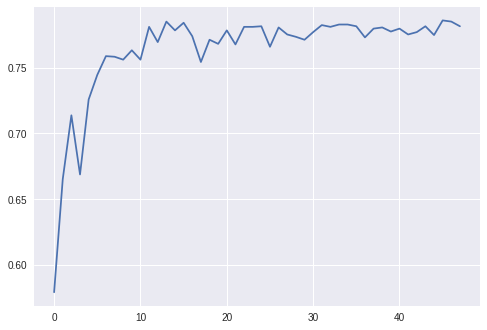

In [34]:
plt.plot(eval_list)

今回の問題で7ユニット以下では表現力不足になる。

2〜50 - 2〜50 - 46    
極端に少ないユニットの層を2個にして観察

In [36]:
import matplotlib.pyplot as plt

def get_eval(num_unit):
    model = models.Sequential()
    model.add(layers.Dense(num_unit, activation='relu', input_shape=(10000,))) #ここ
    model.add(layers.Dense(num_unit, activation='relu')) #ここ
    model.add(layers.Dense(46, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    model.fit(partial_x_train,
              partial_y_train,
              epochs=10,
              batch_size=128,
              validation_data=(x_val, y_val))
    return model.evaluate(x_test, one_hot_test_labels)[1]
eval_list = []
for num_unit in range(2, 50):
    eval_list.append(get_eval(num_unit))
    

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 406us/step - loss: 3.6053 - acc: 0.0603 - val_loss: 3.3966 - val_acc: 0.0590
Epoch 2/10
7982/7982 [==============================] - 1s 98us/step - loss: 3.1609 - acc: 0.0614 - val_loss: 2.9266 - val_acc: 0.0650
Epoch 3/10
7982/7982 [==============================] - 1s 98us/step - loss: 2.6925 - acc: 0.1899 - val_loss: 2.5038 - val_acc: 0.2270
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 2.3449 - acc: 0.2742 - val_loss: 2.2288 - val_acc: 0.3890
Epoch 5/10
7982/7982 [==============================] - 1s 98us/step - loss: 2.1445 - acc: 0.3561 - val_loss: 2.0868 - val_acc: 0.3540
Epoch 6/10
7982/7982 [==============================] - 1s 96us/step - loss: 2.0354 - acc: 0.3514 - val_loss: 2.0090 - val_acc: 0.3540
Epoch 7/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.9555 - acc: 0.3841 - val_loss: 1.9373 - val_acc: 0.4390
Epoch 

2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 416us/step - loss: 3.6491 - acc: 0.0500 - val_loss: 3.4611 - val_acc: 0.0590
Epoch 2/10
7982/7982 [==============================] - 1s 100us/step - loss: 3.2634 - acc: 0.0935 - val_loss: 3.0223 - val_acc: 0.2220
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 2.8075 - acc: 0.2164 - val_loss: 2.5735 - val_acc: 0.2220
Epoch 4/10
7982/7982 [==============================] - 1s 98us/step - loss: 2.4260 - acc: 0.2230 - val_loss: 2.2711 - val_acc: 0.3600
Epoch 5/10
7982/7982 [==============================] - 1s 98us/step - loss: 2.2096 - acc: 0.3534 - val_loss: 2.1326 - val_acc: 0.3550
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 2.1029 - acc: 0.3537 - val_loss: 2.0613 - val_acc: 0.3550
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 2.03

7982/7982 [==============================] - 1s 98us/step - loss: 1.9451 - acc: 0.3677 - val_loss: 1.9474 - val_acc: 0.3830
Epoch 10/10
2246/2246 [==============================] - 0s 136us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 466us/step - loss: 3.4919 - acc: 0.2864 - val_loss: 3.0977 - val_acc: 0.3760
Epoch 2/10
7982/7982 [==============================] - 1s 99us/step - loss: 2.7037 - acc: 0.3795 - val_loss: 2.3524 - val_acc: 0.3920
Epoch 3/10
7982/7982 [==============================] - 1s 98us/step - loss: 2.1191 - acc: 0.4335 - val_loss: 1.9537 - val_acc: 0.4930
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 1.8095 - acc: 0.5568 - val_loss: 1.7508 - val_acc: 0.5760
Epoch 5/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.6332 - acc: 0.5930 - val_loss: 1.6429 - val_acc: 0.5850
Epoch 6/10
7982/7982 [==============================] - 1s 102us/step - loss: 1.

7982/7982 [==============================] - 1s 100us/step - loss: 1.3877 - acc: 0.6233 - val_loss: 1.5185 - val_acc: 0.6070
Epoch 9/10
7982/7982 [==============================] - 1s 102us/step - loss: 1.3313 - acc: 0.6428 - val_loss: 1.4975 - val_acc: 0.6120
Epoch 10/10
2246/2246 [==============================] - 0s 146us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 419us/step - loss: 3.5357 - acc: 0.2149 - val_loss: 3.1284 - val_acc: 0.2430
Epoch 2/10
7982/7982 [==============================] - 1s 96us/step - loss: 2.7278 - acc: 0.2684 - val_loss: 2.3465 - val_acc: 0.3340
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 2.0566 - acc: 0.5324 - val_loss: 1.8682 - val_acc: 0.5820
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.7080 - acc: 0.5995 - val_loss: 1.6498 - val_acc: 0.5950
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.

7982/7982 [==============================] - 1s 98us/step - loss: 1.3042 - acc: 0.6735 - val_loss: 1.4198 - val_acc: 0.6520
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2292 - acc: 0.6858 - val_loss: 1.3818 - val_acc: 0.6730
Epoch 9/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.1654 - acc: 0.7042 - val_loss: 1.3566 - val_acc: 0.6790
Epoch 10/10
2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 435us/step - loss: 3.5175 - acc: 0.2927 - val_loss: 3.0564 - val_acc: 0.3940
Epoch 2/10
7982/7982 [==============================] - 1s 104us/step - loss: 2.5405 - acc: 0.4731 - val_loss: 2.1364 - val_acc: 0.5810
Epoch 3/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.8457 - acc: 0.6180 - val_loss: 1.7034 - val_acc: 0.6090
Epoch 4/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.5

7982/7982 [==============================] - 1s 99us/step - loss: 1.2639 - acc: 0.6780 - val_loss: 1.3849 - val_acc: 0.6720
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 1.1762 - acc: 0.7136 - val_loss: 1.3354 - val_acc: 0.6890
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.1014 - acc: 0.7311 - val_loss: 1.3014 - val_acc: 0.6990
Epoch 9/10
7982/7982 [==============================] - 1s 101us/step - loss: 1.0320 - acc: 0.7477 - val_loss: 1.2670 - val_acc: 0.7090
Epoch 10/10
2246/2246 [==============================] - 0s 140us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 432us/step - loss: 3.3967 - acc: 0.1086 - val_loss: 2.8417 - val_acc: 0.3750
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 2.3022 - acc: 0.5606 - val_loss: 1.9034 - val_acc: 0.5740
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.

7982/7982 [==============================] - 1s 97us/step - loss: 1.2933 - acc: 0.6944 - val_loss: 1.3472 - val_acc: 0.6800
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.1768 - acc: 0.7259 - val_loss: 1.2930 - val_acc: 0.6970
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.0859 - acc: 0.7440 - val_loss: 1.2479 - val_acc: 0.6990
Epoch 8/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.0092 - acc: 0.7557 - val_loss: 1.2212 - val_acc: 0.7020
Epoch 9/10
7982/7982 [==============================] - 1s 94us/step - loss: 0.9414 - acc: 0.7725 - val_loss: 1.1988 - val_acc: 0.7120
Epoch 10/10
2246/2246 [==============================] - 0s 144us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 435us/step - loss: 3.3636 - acc: 0.1590 - val_loss: 2.9235 - val_acc: 0.2650
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 2.49

7982/7982 [==============================] - 1s 100us/step - loss: 1.5051 - acc: 0.6530 - val_loss: 1.4743 - val_acc: 0.6440
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.3002 - acc: 0.6850 - val_loss: 1.3589 - val_acc: 0.6750
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.1725 - acc: 0.7241 - val_loss: 1.2981 - val_acc: 0.6980
Epoch 7/10
7982/7982 [==============================] - 1s 100us/step - loss: 1.0760 - acc: 0.7517 - val_loss: 1.2518 - val_acc: 0.7170
Epoch 8/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.9944 - acc: 0.7711 - val_loss: 1.2176 - val_acc: 0.7300
Epoch 9/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.9233 - acc: 0.7864 - val_loss: 1.1960 - val_acc: 0.7270
Epoch 10/10
2246/2246 [==============================] - 0s 142us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 433us/step - loss: 

7982/7982 [==============================] - 1s 96us/step - loss: 1.8655 - acc: 0.6085 - val_loss: 1.7023 - val_acc: 0.6260
Epoch 4/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.5305 - acc: 0.6571 - val_loss: 1.5142 - val_acc: 0.6460
Epoch 5/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.3559 - acc: 0.6769 - val_loss: 1.4145 - val_acc: 0.6580
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.2392 - acc: 0.6979 - val_loss: 1.3464 - val_acc: 0.6710
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.1473 - acc: 0.7235 - val_loss: 1.2956 - val_acc: 0.6910
Epoch 8/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.0660 - acc: 0.7449 - val_loss: 1.2624 - val_acc: 0.7060
Epoch 9/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.9943 - acc: 0.7595 - val_loss: 1.2290 - val_acc: 0.7140
Epoch 10/10
2246/2246 [==============================] - 0s 142us/

7982/7982 [==============================] - 1s 96us/step - loss: 1.9738 - acc: 0.4440 - val_loss: 1.6917 - val_acc: 0.5980
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.5136 - acc: 0.6376 - val_loss: 1.4396 - val_acc: 0.6500
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2859 - acc: 0.6852 - val_loss: 1.3177 - val_acc: 0.6950
Epoch 5/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.1299 - acc: 0.7319 - val_loss: 1.2403 - val_acc: 0.7230
Epoch 6/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.0105 - acc: 0.7620 - val_loss: 1.1829 - val_acc: 0.7330
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.9143 - acc: 0.7858 - val_loss: 1.1441 - val_acc: 0.7510
Epoch 8/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.8303 - acc: 0.8072 - val_loss: 1.1280 - val_acc: 0.7520
Epoch 9/10
7982/7982 [==============================] - 1s 97us/st

7982/7982 [==============================] - 4s 442us/step - loss: 3.0177 - acc: 0.2605 - val_loss: 2.3251 - val_acc: 0.5280
Epoch 2/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.8883 - acc: 0.6031 - val_loss: 1.6304 - val_acc: 0.6310
Epoch 3/10
7982/7982 [==============================] - 1s 100us/step - loss: 1.4064 - acc: 0.6872 - val_loss: 1.3717 - val_acc: 0.6780
Epoch 4/10
7982/7982 [==============================] - 1s 102us/step - loss: 1.1685 - acc: 0.7375 - val_loss: 1.2406 - val_acc: 0.7230
Epoch 5/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.0162 - acc: 0.7726 - val_loss: 1.1710 - val_acc: 0.7460
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.8976 - acc: 0.7994 - val_loss: 1.1106 - val_acc: 0.7570
Epoch 7/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.7988 - acc: 0.8196 - val_loss: 1.0793 - val_acc: 0.7650
Epoch 8/10
7982/7982 [==============================] - 1s 101u

2246/2246 [==============================] - 0s 145us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 450us/step - loss: 3.0837 - acc: 0.2566 - val_loss: 2.4057 - val_acc: 0.3820
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.9576 - acc: 0.5345 - val_loss: 1.6890 - val_acc: 0.6190
Epoch 3/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.4894 - acc: 0.6575 - val_loss: 1.4547 - val_acc: 0.6580
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2819 - acc: 0.7051 - val_loss: 1.3302 - val_acc: 0.6990
Epoch 5/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.1332 - acc: 0.7378 - val_loss: 1.2394 - val_acc: 0.7250
Epoch 6/10
7982/7982 [==============================] - 1s 101us/step - loss: 1.0091 - acc: 0.7707 - val_loss: 1.1722 - val_acc: 0.7430
Epoch 7/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.90

2246/2246 [==============================] - 0s 142us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 453us/step - loss: 3.1178 - acc: 0.1439 - val_loss: 2.5130 - val_acc: 0.2220
Epoch 2/10
7982/7982 [==============================] - 1s 100us/step - loss: 2.0833 - acc: 0.4992 - val_loss: 1.7740 - val_acc: 0.5930
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.5464 - acc: 0.6289 - val_loss: 1.4566 - val_acc: 0.6440
Epoch 4/10
7982/7982 [==============================] - 1s 100us/step - loss: 1.2711 - acc: 0.7018 - val_loss: 1.2987 - val_acc: 0.7080
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.0952 - acc: 0.7568 - val_loss: 1.2072 - val_acc: 0.7330
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.9597 - acc: 0.7964 - val_loss: 1.1397 - val_acc: 0.7610
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.8

7982/7982 [==============================] - 1s 100us/step - loss: 0.6745 - acc: 0.8512 - val_loss: 1.0349 - val_acc: 0.7810
Epoch 10/10
2246/2246 [==============================] - 0s 142us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 455us/step - loss: 2.7047 - acc: 0.5132 - val_loss: 1.8821 - val_acc: 0.6220
Epoch 2/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.5770 - acc: 0.6561 - val_loss: 1.4137 - val_acc: 0.6570
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2451 - acc: 0.7127 - val_loss: 1.2636 - val_acc: 0.7190
Epoch 4/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.0600 - acc: 0.7636 - val_loss: 1.1741 - val_acc: 0.7490
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.9162 - acc: 0.7980 - val_loss: 1.1151 - val_acc: 0.7610
Epoch 6/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.7

7982/7982 [==============================] - 1s 96us/step - loss: 0.6084 - acc: 0.8573 - val_loss: 1.0578 - val_acc: 0.7800
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.5319 - acc: 0.8742 - val_loss: 1.0357 - val_acc: 0.7860
Epoch 10/10
2246/2246 [==============================] - 0s 144us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 461us/step - loss: 2.9150 - acc: 0.4468 - val_loss: 2.0959 - val_acc: 0.5950
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.7103 - acc: 0.6373 - val_loss: 1.4762 - val_acc: 0.6540
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.3073 - acc: 0.7065 - val_loss: 1.2982 - val_acc: 0.7000
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 1.1122 - acc: 0.7546 - val_loss: 1.1849 - val_acc: 0.7390
Epoch 5/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.

7982/7982 [==============================] - 1s 97us/step - loss: 0.7382 - acc: 0.8316 - val_loss: 1.0505 - val_acc: 0.7730
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.6499 - acc: 0.8495 - val_loss: 1.0290 - val_acc: 0.7810
Epoch 9/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.5733 - acc: 0.8683 - val_loss: 1.0217 - val_acc: 0.7820
Epoch 10/10
2246/2246 [==============================] - 0s 148us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 464us/step - loss: 2.6661 - acc: 0.4090 - val_loss: 1.8898 - val_acc: 0.5920
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.5686 - acc: 0.6300 - val_loss: 1.4483 - val_acc: 0.6610
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.2314 - acc: 0.7151 - val_loss: 1.2886 - val_acc: 0.7000
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.03

7982/7982 [==============================] - 1s 97us/step - loss: 0.7565 - acc: 0.8240 - val_loss: 1.0544 - val_acc: 0.7640
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6539 - acc: 0.8463 - val_loss: 1.0124 - val_acc: 0.7830
Epoch 8/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.5644 - acc: 0.8664 - val_loss: 0.9844 - val_acc: 0.7930
Epoch 9/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.4888 - acc: 0.8852 - val_loss: 0.9794 - val_acc: 0.7980
Epoch 10/10
2246/2246 [==============================] - 0s 141us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 464us/step - loss: 2.5686 - acc: 0.4103 - val_loss: 1.8153 - val_acc: 0.5860
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.5333 - acc: 0.6452 - val_loss: 1.3875 - val_acc: 0.6700
Epoch 3/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.20

7982/7982 [==============================] - 1s 96us/step - loss: 0.8827 - acc: 0.7999 - val_loss: 1.0646 - val_acc: 0.7600
Epoch 6/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.7648 - acc: 0.8257 - val_loss: 1.0186 - val_acc: 0.7720
Epoch 7/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.6588 - acc: 0.8504 - val_loss: 0.9841 - val_acc: 0.7830
Epoch 8/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.5695 - acc: 0.8731 - val_loss: 0.9622 - val_acc: 0.7970
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.4911 - acc: 0.8882 - val_loss: 0.9496 - val_acc: 0.7960
Epoch 10/10
2246/2246 [==============================] - 0s 139us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 472us/step - loss: 2.7126 - acc: 0.5125 - val_loss: 1.9027 - val_acc: 0.6090
Epoch 2/10
7982/7982 [==============================] - 1s 95us/step - loss: 1.58

7982/7982 [==============================] - 1s 96us/step - loss: 1.0362 - acc: 0.7636 - val_loss: 1.1926 - val_acc: 0.7400
Epoch 5/10
7982/7982 [==============================] - 1s 95us/step - loss: 0.8801 - acc: 0.8047 - val_loss: 1.1313 - val_acc: 0.7550
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.7511 - acc: 0.8358 - val_loss: 1.0969 - val_acc: 0.7630
Epoch 7/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.6423 - acc: 0.8544 - val_loss: 1.0700 - val_acc: 0.7840
Epoch 8/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.5514 - acc: 0.8806 - val_loss: 1.0586 - val_acc: 0.7870
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.4755 - acc: 0.8990 - val_loss: 1.0629 - val_acc: 0.7850
Epoch 10/10
2246/2246 [==============================] - 0s 148us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 480us/step - loss: 2.7

7982/7982 [==============================] - 1s 104us/step - loss: 1.1267 - acc: 0.7451 - val_loss: 1.1890 - val_acc: 0.7350
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.9320 - acc: 0.7886 - val_loss: 1.1067 - val_acc: 0.7530
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.7844 - acc: 0.8212 - val_loss: 1.0401 - val_acc: 0.7670
Epoch 6/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.6609 - acc: 0.8450 - val_loss: 1.0047 - val_acc: 0.7820
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.5557 - acc: 0.8687 - val_loss: 0.9871 - val_acc: 0.7910
Epoch 8/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.4679 - acc: 0.8941 - val_loss: 0.9812 - val_acc: 0.7920
Epoch 9/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3949 - acc: 0.9104 - val_loss: 0.9721 - val_acc: 0.7950
Epoch 10/10
2246/2246 [==============================] - 0s 14

7982/7982 [==============================] - 1s 100us/step - loss: 1.5114 - acc: 0.6793 - val_loss: 1.3575 - val_acc: 0.6850
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.1600 - acc: 0.7314 - val_loss: 1.2027 - val_acc: 0.7240
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.9671 - acc: 0.7722 - val_loss: 1.1155 - val_acc: 0.7410
Epoch 5/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.8094 - acc: 0.8181 - val_loss: 1.0478 - val_acc: 0.7660
Epoch 6/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.6794 - acc: 0.8494 - val_loss: 1.0024 - val_acc: 0.7880
Epoch 7/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.5714 - acc: 0.8755 - val_loss: 0.9938 - val_acc: 0.7920
Epoch 8/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.4822 - acc: 0.8951 - val_loss: 0.9702 - val_acc: 0.7980
Epoch 9/10
7982/7982 [==============================] - 1s 98us/

7982/7982 [==============================] - 4s 491us/step - loss: 2.3821 - acc: 0.5338 - val_loss: 1.6533 - val_acc: 0.6160
Epoch 2/10
7982/7982 [==============================] - 1s 100us/step - loss: 1.3876 - acc: 0.6822 - val_loss: 1.3287 - val_acc: 0.7100
Epoch 3/10
7982/7982 [==============================] - 1s 100us/step - loss: 1.0858 - acc: 0.7494 - val_loss: 1.1760 - val_acc: 0.7500
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.8925 - acc: 0.8008 - val_loss: 1.0907 - val_acc: 0.7730
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.7425 - acc: 0.8294 - val_loss: 1.0424 - val_acc: 0.7800
Epoch 6/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.6163 - acc: 0.8550 - val_loss: 1.0109 - val_acc: 0.7890
Epoch 7/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.5110 - acc: 0.8846 - val_loss: 0.9798 - val_acc: 0.8020
Epoch 8/10
7982/7982 [==============================] - 1s 

2246/2246 [==============================] - 0s 149us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 490us/step - loss: 2.5517 - acc: 0.4772 - val_loss: 1.7280 - val_acc: 0.5940
Epoch 2/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.4249 - acc: 0.6877 - val_loss: 1.2978 - val_acc: 0.6970
Epoch 3/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.0939 - acc: 0.7478 - val_loss: 1.1444 - val_acc: 0.7320
Epoch 4/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.8984 - acc: 0.7964 - val_loss: 1.0619 - val_acc: 0.7560
Epoch 5/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.7419 - acc: 0.8340 - val_loss: 1.0062 - val_acc: 0.7770
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6157 - acc: 0.8627 - val_loss: 0.9632 - val_acc: 0.7920
Epoch 7/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.51

2246/2246 [==============================] - 0s 147us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 493us/step - loss: 2.5352 - acc: 0.4899 - val_loss: 1.6318 - val_acc: 0.6330
Epoch 2/10
7982/7982 [==============================] - 1s 96us/step - loss: 1.3467 - acc: 0.7076 - val_loss: 1.2529 - val_acc: 0.7160
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.0400 - acc: 0.7686 - val_loss: 1.1429 - val_acc: 0.7310
Epoch 4/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.8510 - acc: 0.8130 - val_loss: 1.0595 - val_acc: 0.7670
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.7007 - acc: 0.8458 - val_loss: 1.0395 - val_acc: 0.7890
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.5786 - acc: 0.8763 - val_loss: 0.9984 - val_acc: 0.7950
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.480

7982/7982 [==============================] - 1s 96us/step - loss: 0.3306 - acc: 0.9307 - val_loss: 0.9972 - val_acc: 0.7940
Epoch 10/10
2246/2246 [==============================] - 0s 147us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 506us/step - loss: 2.4334 - acc: 0.5783 - val_loss: 1.5769 - val_acc: 0.6710
Epoch 2/10
7982/7982 [==============================] - 1s 102us/step - loss: 1.3261 - acc: 0.7142 - val_loss: 1.2388 - val_acc: 0.7260
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss: 1.0261 - acc: 0.7761 - val_loss: 1.1060 - val_acc: 0.7420
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.8295 - acc: 0.8162 - val_loss: 1.0334 - val_acc: 0.7590
Epoch 5/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6744 - acc: 0.8495 - val_loss: 0.9659 - val_acc: 0.7890
Epoch 6/10
7982/7982 [==============================] - 1s 101us/step - loss: 

7982/7982 [==============================] - 1s 102us/step - loss: 0.3683 - acc: 0.9208 - val_loss: 0.9285 - val_acc: 0.8080
Epoch 9/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3054 - acc: 0.9318 - val_loss: 0.9218 - val_acc: 0.8080
Epoch 10/10
2246/2246 [==============================] - 0s 147us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 506us/step - loss: 2.3004 - acc: 0.5505 - val_loss: 1.5587 - val_acc: 0.6500
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.3258 - acc: 0.7045 - val_loss: 1.2228 - val_acc: 0.7150
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.0283 - acc: 0.7638 - val_loss: 1.0883 - val_acc: 0.7400
Epoch 4/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.8254 - acc: 0.8153 - val_loss: 0.9757 - val_acc: 0.7830
Epoch 5/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.

7982/7982 [==============================] - 1s 99us/step - loss: 0.4327 - acc: 0.9082 - val_loss: 0.8867 - val_acc: 0.8030
Epoch 8/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.3558 - acc: 0.9233 - val_loss: 0.9009 - val_acc: 0.7960
Epoch 9/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3003 - acc: 0.9336 - val_loss: 0.9064 - val_acc: 0.8060
Epoch 10/10
2246/2246 [==============================] - 0s 148us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 507us/step - loss: 2.3748 - acc: 0.5392 - val_loss: 1.5699 - val_acc: 0.6530
Epoch 2/10
7982/7982 [==============================] - 1s 103us/step - loss: 1.3146 - acc: 0.7112 - val_loss: 1.2553 - val_acc: 0.7130
Epoch 3/10
7982/7982 [==============================] - 1s 103us/step - loss: 1.0194 - acc: 0.7652 - val_loss: 1.1215 - val_acc: 0.7440
Epoch 4/10
7982/7982 [==============================] - 1s 100us/step - loss: 

7982/7982 [==============================] - 1s 101us/step - loss: 0.5133 - acc: 0.8882 - val_loss: 0.9326 - val_acc: 0.8060
Epoch 7/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.4142 - acc: 0.9085 - val_loss: 0.9751 - val_acc: 0.7910
Epoch 8/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3386 - acc: 0.9260 - val_loss: 0.9221 - val_acc: 0.8160
Epoch 9/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2828 - acc: 0.9380 - val_loss: 0.9601 - val_acc: 0.8160
Epoch 10/10
2246/2246 [==============================] - 0s 146us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 516us/step - loss: 2.2405 - acc: 0.5571 - val_loss: 1.4781 - val_acc: 0.6750
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2397 - acc: 0.7304 - val_loss: 1.1562 - val_acc: 0.7460
Epoch 3/10
7982/7982 [==============================] - 1s 97us/step - loss: 

7982/7982 [==============================] - 1s 101us/step - loss: 0.6048 - acc: 0.8681 - val_loss: 0.9288 - val_acc: 0.8030
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.4919 - acc: 0.8925 - val_loss: 0.9228 - val_acc: 0.8060
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3992 - acc: 0.9122 - val_loss: 0.9293 - val_acc: 0.7970
Epoch 8/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3293 - acc: 0.9276 - val_loss: 0.9457 - val_acc: 0.8060
Epoch 9/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.2777 - acc: 0.9394 - val_loss: 0.9512 - val_acc: 0.8150
Epoch 10/10
2246/2246 [==============================] - 0s 142us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 514us/step - loss: 2.6558 - acc: 0.4883 - val_loss: 1.7272 - val_acc: 0.6220
Epoch 2/10
7982/7982 [==============================] - 1s 98us/step - loss: 1

7982/7982 [==============================] - 1s 97us/step - loss: 0.8289 - acc: 0.8135 - val_loss: 1.0285 - val_acc: 0.7630
Epoch 5/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.6675 - acc: 0.8479 - val_loss: 0.9751 - val_acc: 0.7790
Epoch 6/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.5389 - acc: 0.8834 - val_loss: 0.9415 - val_acc: 0.7980
Epoch 7/10
7982/7982 [==============================] - 1s 96us/step - loss: 0.4369 - acc: 0.9062 - val_loss: 0.9455 - val_acc: 0.8070
Epoch 8/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.3605 - acc: 0.9241 - val_loss: 0.9384 - val_acc: 0.8020
Epoch 9/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2981 - acc: 0.9345 - val_loss: 0.9267 - val_acc: 0.8170
Epoch 10/10
2246/2246 [==============================] - 0s 146us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 521us/step - loss: 2.38

7982/7982 [==============================] - 1s 96us/step - loss: 0.9870 - acc: 0.7824 - val_loss: 1.0928 - val_acc: 0.7660
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.7748 - acc: 0.8324 - val_loss: 1.0228 - val_acc: 0.7740
Epoch 5/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6140 - acc: 0.8661 - val_loss: 0.9490 - val_acc: 0.7980
Epoch 6/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.4906 - acc: 0.8968 - val_loss: 0.9450 - val_acc: 0.8080
Epoch 7/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.3965 - acc: 0.9143 - val_loss: 0.9442 - val_acc: 0.7940
Epoch 8/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.3263 - acc: 0.9290 - val_loss: 0.9391 - val_acc: 0.8060
Epoch 9/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2747 - acc: 0.9370 - val_loss: 0.9608 - val_acc: 0.8080
Epoch 10/10
2246/2246 [==============================] - 0s 144

7982/7982 [==============================] - 1s 102us/step - loss: 1.2426 - acc: 0.7216 - val_loss: 1.2083 - val_acc: 0.7220
Epoch 3/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.9642 - acc: 0.7853 - val_loss: 1.0900 - val_acc: 0.7640
Epoch 4/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.7625 - acc: 0.8297 - val_loss: 1.0420 - val_acc: 0.7670
Epoch 5/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.6068 - acc: 0.8606 - val_loss: 0.9768 - val_acc: 0.7830
Epoch 6/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.4840 - acc: 0.8893 - val_loss: 0.9363 - val_acc: 0.8070
Epoch 7/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3889 - acc: 0.9147 - val_loss: 0.9238 - val_acc: 0.8170
Epoch 8/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.3195 - acc: 0.9288 - val_loss: 0.9318 - val_acc: 0.8100
Epoch 9/10
7982/7982 [==============================] - 1s 

7982/7982 [==============================] - 4s 532us/step - loss: 2.2431 - acc: 0.5682 - val_loss: 1.4749 - val_acc: 0.6720
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2181 - acc: 0.7340 - val_loss: 1.1751 - val_acc: 0.7470
Epoch 3/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.9109 - acc: 0.8058 - val_loss: 1.0286 - val_acc: 0.7780
Epoch 4/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.6982 - acc: 0.8447 - val_loss: 0.9691 - val_acc: 0.8040
Epoch 5/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.5366 - acc: 0.8840 - val_loss: 0.9183 - val_acc: 0.8130
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.4213 - acc: 0.9131 - val_loss: 0.9150 - val_acc: 0.8100
Epoch 7/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.3358 - acc: 0.9288 - val_loss: 0.9087 - val_acc: 0.8220
Epoch 8/10
7982/7982 [==============================] - 1s 100

2246/2246 [==============================] - 0s 150us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 540us/step - loss: 2.2875 - acc: 0.5558 - val_loss: 1.4611 - val_acc: 0.6740
Epoch 2/10
7982/7982 [==============================] - 1s 103us/step - loss: 1.2046 - acc: 0.7446 - val_loss: 1.1669 - val_acc: 0.7510
Epoch 3/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.8928 - acc: 0.8087 - val_loss: 1.0336 - val_acc: 0.7890
Epoch 4/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.6892 - acc: 0.8519 - val_loss: 0.9745 - val_acc: 0.7880
Epoch 5/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.5378 - acc: 0.8851 - val_loss: 0.9445 - val_acc: 0.8010
Epoch 6/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.4257 - acc: 0.9132 - val_loss: 0.9036 - val_acc: 0.8120
Epoch 7/10
7982/7982 [==============================] - 1s 104us/step - loss:

7982/7982 [==============================] - 1s 105us/step - loss: 0.2393 - acc: 0.9429 - val_loss: 0.9386 - val_acc: 0.8120
Epoch 10/10
2246/2246 [==============================] - 0s 149us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 544us/step - loss: 2.4539 - acc: 0.5232 - val_loss: 1.5165 - val_acc: 0.6660
Epoch 2/10
7982/7982 [==============================] - 1s 102us/step - loss: 1.2134 - acc: 0.7392 - val_loss: 1.1531 - val_acc: 0.7500
Epoch 3/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.8894 - acc: 0.8042 - val_loss: 1.0397 - val_acc: 0.7720
Epoch 4/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.6860 - acc: 0.8498 - val_loss: 0.9596 - val_acc: 0.7880
Epoch 5/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.5304 - acc: 0.8839 - val_loss: 0.9350 - val_acc: 0.7990
Epoch 6/10
7982/7982 [==============================] - 1s 102us/step - loss:

7982/7982 [==============================] - 1s 98us/step - loss: 0.2704 - acc: 0.9391 - val_loss: 0.9454 - val_acc: 0.8150
Epoch 9/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.2293 - acc: 0.9446 - val_loss: 0.9692 - val_acc: 0.8040
Epoch 10/10
2246/2246 [==============================] - 0s 151us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 544us/step - loss: 2.1572 - acc: 0.5869 - val_loss: 1.4296 - val_acc: 0.6830
Epoch 2/10
7982/7982 [==============================] - 1s 103us/step - loss: 1.1706 - acc: 0.7338 - val_loss: 1.1431 - val_acc: 0.7370
Epoch 3/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.8726 - acc: 0.8024 - val_loss: 1.0145 - val_acc: 0.7850
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.6712 - acc: 0.8564 - val_loss: 0.9657 - val_acc: 0.7970
Epoch 5/10
7982/7982 [==============================] - 1s 109us/step - loss: 

7982/7982 [==============================] - 1s 107us/step - loss: 0.3299 - acc: 0.9328 - val_loss: 0.9202 - val_acc: 0.8170
Epoch 8/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.2727 - acc: 0.9399 - val_loss: 0.9351 - val_acc: 0.8180
Epoch 9/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.2274 - acc: 0.9485 - val_loss: 0.9823 - val_acc: 0.8150
Epoch 10/10
2246/2246 [==============================] - 0s 153us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 556us/step - loss: 2.0823 - acc: 0.5606 - val_loss: 1.4311 - val_acc: 0.6840
Epoch 2/10
7982/7982 [==============================] - 1s 104us/step - loss: 1.1778 - acc: 0.7258 - val_loss: 1.1987 - val_acc: 0.7160
Epoch 3/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.8806 - acc: 0.7979 - val_loss: 1.0292 - val_acc: 0.7660
Epoch 4/10
7982/7982 [==============================] - 1s 102us/step - loss

7982/7982 [==============================] - 1s 106us/step - loss: 0.3942 - acc: 0.9138 - val_loss: 0.8883 - val_acc: 0.8160
Epoch 7/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.3126 - acc: 0.9278 - val_loss: 0.8921 - val_acc: 0.8210
Epoch 8/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.2560 - acc: 0.9381 - val_loss: 0.9300 - val_acc: 0.8210
Epoch 9/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.2189 - acc: 0.9481 - val_loss: 0.9152 - val_acc: 0.8260
Epoch 10/10
2246/2246 [==============================] - 0s 150us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 553us/step - loss: 2.1879 - acc: 0.5784 - val_loss: 1.4605 - val_acc: 0.6720
Epoch 2/10
7982/7982 [==============================] - 1s 97us/step - loss: 1.2049 - acc: 0.7387 - val_loss: 1.1771 - val_acc: 0.7260
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss:

7982/7982 [==============================] - 1s 100us/step - loss: 0.5280 - acc: 0.8849 - val_loss: 0.9188 - val_acc: 0.8090
Epoch 6/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.4089 - acc: 0.9093 - val_loss: 0.9201 - val_acc: 0.8030
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3223 - acc: 0.9283 - val_loss: 0.9195 - val_acc: 0.8100
Epoch 8/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.2634 - acc: 0.9401 - val_loss: 0.9585 - val_acc: 0.8050
Epoch 9/10
7982/7982 [==============================] - 1s 97us/step - loss: 0.2250 - acc: 0.9461 - val_loss: 0.9691 - val_acc: 0.8060
Epoch 10/10
2246/2246 [==============================] - 0s 148us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 558us/step - loss: 2.1281 - acc: 0.5813 - val_loss: 1.4008 - val_acc: 0.6850
Epoch 2/10
7982/7982 [==============================] - 1s 105us/step - loss:

7982/7982 [==============================] - 1s 104us/step - loss: 0.6411 - acc: 0.8646 - val_loss: 0.9552 - val_acc: 0.7950
Epoch 5/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.4904 - acc: 0.8973 - val_loss: 0.9152 - val_acc: 0.8090
Epoch 6/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.3794 - acc: 0.9197 - val_loss: 0.9030 - val_acc: 0.8190
Epoch 7/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.3044 - acc: 0.9359 - val_loss: 0.9088 - val_acc: 0.8190
Epoch 8/10
7982/7982 [==============================] - 1s 106us/step - loss: 0.2503 - acc: 0.9421 - val_loss: 0.9446 - val_acc: 0.8140
Epoch 9/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2120 - acc: 0.9476 - val_loss: 0.9397 - val_acc: 0.8150
Epoch 10/10
2246/2246 [==============================] - 0s 144us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 4s 558us/step - loss

7982/7982 [==============================] - 1s 101us/step - loss: 0.8758 - acc: 0.8087 - val_loss: 1.0235 - val_acc: 0.7810
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6630 - acc: 0.8568 - val_loss: 0.9919 - val_acc: 0.7840
Epoch 5/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.5077 - acc: 0.8923 - val_loss: 0.9195 - val_acc: 0.8130
Epoch 6/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.3933 - acc: 0.9144 - val_loss: 0.9169 - val_acc: 0.8160
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.3120 - acc: 0.9282 - val_loss: 0.9188 - val_acc: 0.8190
Epoch 8/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.2562 - acc: 0.9419 - val_loss: 0.9177 - val_acc: 0.8110
Epoch 9/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2156 - acc: 0.9478 - val_loss: 0.9206 - val_acc: 0.8170
Epoch 10/10
2246/2246 [==============================] - 0s 152u

7982/7982 [==============================] - 1s 106us/step - loss: 1.1567 - acc: 0.7504 - val_loss: 1.1242 - val_acc: 0.7480
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.8500 - acc: 0.8160 - val_loss: 0.9984 - val_acc: 0.7860
Epoch 4/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.6404 - acc: 0.8612 - val_loss: 0.9377 - val_acc: 0.8010
Epoch 5/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.4892 - acc: 0.8959 - val_loss: 0.9229 - val_acc: 0.8060
Epoch 6/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.3760 - acc: 0.9191 - val_loss: 0.8939 - val_acc: 0.8130
Epoch 7/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.2989 - acc: 0.9339 - val_loss: 0.9346 - val_acc: 0.8050
Epoch 8/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.2413 - acc: 0.9442 - val_loss: 0.9434 - val_acc: 0.8130
Epoch 9/10
7982/7982 [==============================] - 1s 

7982/7982 [==============================] - 5s 570us/step - loss: 2.0070 - acc: 0.5927 - val_loss: 1.3545 - val_acc: 0.6860
Epoch 2/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.1369 - acc: 0.7514 - val_loss: 1.0801 - val_acc: 0.7610
Epoch 3/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.8366 - acc: 0.8190 - val_loss: 0.9579 - val_acc: 0.7890
Epoch 4/10
7982/7982 [==============================] - 1s 98us/step - loss: 0.6325 - acc: 0.8584 - val_loss: 0.9107 - val_acc: 0.8040
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.4782 - acc: 0.8915 - val_loss: 0.8629 - val_acc: 0.8220
Epoch 6/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.3664 - acc: 0.9197 - val_loss: 0.8604 - val_acc: 0.8240
Epoch 7/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.2919 - acc: 0.9334 - val_loss: 0.9002 - val_acc: 0.8210
Epoch 8/10
7982/7982 [==============================] - 1s 103

2246/2246 [==============================] - 0s 147us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 571us/step - loss: 2.0037 - acc: 0.6074 - val_loss: 1.3444 - val_acc: 0.6890
Epoch 2/10
7982/7982 [==============================] - 1s 98us/step - loss: 1.0996 - acc: 0.7538 - val_loss: 1.1118 - val_acc: 0.7510
Epoch 3/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.8001 - acc: 0.8256 - val_loss: 1.0251 - val_acc: 0.7790
Epoch 4/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.5942 - acc: 0.8710 - val_loss: 0.9299 - val_acc: 0.8060
Epoch 5/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.4458 - acc: 0.9045 - val_loss: 0.9287 - val_acc: 0.7950
Epoch 6/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.3442 - acc: 0.9253 - val_loss: 0.9539 - val_acc: 0.7960
Epoch 7/10
7982/7982 [==============================] - 1s 100us/step - loss: 

2246/2246 [==============================] - 0s 150us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 580us/step - loss: 2.0477 - acc: 0.5685 - val_loss: 1.3583 - val_acc: 0.6890
Epoch 2/10
7982/7982 [==============================] - 1s 104us/step - loss: 1.1402 - acc: 0.7414 - val_loss: 1.1188 - val_acc: 0.7360
Epoch 3/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.8389 - acc: 0.8103 - val_loss: 0.9808 - val_acc: 0.7880
Epoch 4/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.6223 - acc: 0.8607 - val_loss: 0.9202 - val_acc: 0.8100
Epoch 5/10
7982/7982 [==============================] - 1s 108us/step - loss: 0.4681 - acc: 0.8993 - val_loss: 0.8851 - val_acc: 0.8200
Epoch 6/10
7982/7982 [==============================] - 1s 106us/step - loss: 0.3583 - acc: 0.9231 - val_loss: 0.8837 - val_acc: 0.8150
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss:

Epoch 9/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.1999 - acc: 0.9488 - val_loss: 0.9423 - val_acc: 0.8140
Epoch 10/10
2246/2246 [==============================] - 0s 152us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 584us/step - loss: 2.0483 - acc: 0.5921 - val_loss: 1.3782 - val_acc: 0.6960
Epoch 2/10
7982/7982 [==============================] - 1s 99us/step - loss: 1.1342 - acc: 0.7494 - val_loss: 1.1314 - val_acc: 0.7610
Epoch 3/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.8265 - acc: 0.8217 - val_loss: 0.9949 - val_acc: 0.7880
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.6113 - acc: 0.8706 - val_loss: 0.9306 - val_acc: 0.7970
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.4565 - acc: 0.9027 - val_loss: 0.9198 - val_acc: 0.8020
Epoch 6/10
7982/7982 [==============================] - 1s 101us/st

7982/7982 [==============================] - 1s 98us/step - loss: 0.2270 - acc: 0.9448 - val_loss: 0.9280 - val_acc: 0.8160
Epoch 9/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.1948 - acc: 0.9498 - val_loss: 0.9381 - val_acc: 0.8170
Epoch 10/10
2246/2246 [==============================] - 0s 147us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 591us/step - loss: 2.2054 - acc: 0.5866 - val_loss: 1.3999 - val_acc: 0.6920
Epoch 2/10
7982/7982 [==============================] - 1s 103us/step - loss: 1.1158 - acc: 0.7603 - val_loss: 1.1280 - val_acc: 0.7580
Epoch 3/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.8083 - acc: 0.8239 - val_loss: 1.0584 - val_acc: 0.7740
Epoch 4/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.6027 - acc: 0.8692 - val_loss: 0.9581 - val_acc: 0.8050
Epoch 5/10
7982/7982 [==============================] - 1s 106us/step - loss:

7982/7982 [==============================] - 1s 104us/step - loss: 0.2762 - acc: 0.9379 - val_loss: 1.0297 - val_acc: 0.7890
Epoch 8/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.2313 - acc: 0.9453 - val_loss: 1.0049 - val_acc: 0.8100
Epoch 9/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.1970 - acc: 0.9479 - val_loss: 0.9767 - val_acc: 0.8160
Epoch 10/10
2246/2246 [==============================] - 0s 149us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 595us/step - loss: 2.0120 - acc: 0.5803 - val_loss: 1.3201 - val_acc: 0.6870
Epoch 2/10
7982/7982 [==============================] - 1s 102us/step - loss: 1.0760 - acc: 0.7687 - val_loss: 1.0445 - val_acc: 0.7780
Epoch 3/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.7522 - acc: 0.8379 - val_loss: 0.9282 - val_acc: 0.8020
Epoch 4/10
7982/7982 [==============================] - 1s 100us/step - loss

7982/7982 [==============================] - 1s 103us/step - loss: 0.3085 - acc: 0.9315 - val_loss: 0.9041 - val_acc: 0.8150
Epoch 7/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2515 - acc: 0.9415 - val_loss: 0.9060 - val_acc: 0.8160
Epoch 8/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2092 - acc: 0.9488 - val_loss: 0.9201 - val_acc: 0.8070
Epoch 9/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.1831 - acc: 0.9516 - val_loss: 0.9750 - val_acc: 0.8030
Epoch 10/10
2246/2246 [==============================] - 0s 152us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 604us/step - loss: 1.9754 - acc: 0.6105 - val_loss: 1.3308 - val_acc: 0.6970
Epoch 2/10
7982/7982 [==============================] - 1s 104us/step - loss: 1.0800 - acc: 0.7580 - val_loss: 1.0966 - val_acc: 0.7570
Epoch 3/10
7982/7982 [==============================] - 1s 103us/step - loss

7982/7982 [==============================] - 1s 105us/step - loss: 0.4251 - acc: 0.9097 - val_loss: 0.9035 - val_acc: 0.8170
Epoch 6/10
7982/7982 [==============================] - 1s 107us/step - loss: 0.3212 - acc: 0.9297 - val_loss: 0.9234 - val_acc: 0.8100
Epoch 7/10
7982/7982 [==============================] - 1s 106us/step - loss: 0.2547 - acc: 0.9432 - val_loss: 0.9409 - val_acc: 0.8210
Epoch 8/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.2119 - acc: 0.9484 - val_loss: 0.9791 - val_acc: 0.8130
Epoch 9/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.1820 - acc: 0.9514 - val_loss: 0.9909 - val_acc: 0.8160
Epoch 10/10
2246/2246 [==============================] - 0s 149us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 608us/step - loss: 1.9601 - acc: 0.5844 - val_loss: 1.3141 - val_acc: 0.7050
Epoch 2/10
7982/7982 [==============================] - 1s 103us/step - loss

7982/7982 [==============================] - 1s 104us/step - loss: 0.5614 - acc: 0.8801 - val_loss: 0.8948 - val_acc: 0.8100
Epoch 5/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.4180 - acc: 0.9105 - val_loss: 0.9241 - val_acc: 0.8080
Epoch 6/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.3184 - acc: 0.9328 - val_loss: 0.8970 - val_acc: 0.8030
Epoch 7/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2569 - acc: 0.9401 - val_loss: 0.8791 - val_acc: 0.8200
Epoch 8/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2145 - acc: 0.9461 - val_loss: 0.9316 - val_acc: 0.8170
Epoch 9/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.1843 - acc: 0.9505 - val_loss: 0.9655 - val_acc: 0.8000
Epoch 10/10
2246/2246 [==============================] - 0s 152us/step
Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 608us/step - loss

7982/7982 [==============================] - 1s 99us/step - loss: 0.7382 - acc: 0.8393 - val_loss: 0.9713 - val_acc: 0.7970
Epoch 4/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.5284 - acc: 0.8871 - val_loss: 0.9076 - val_acc: 0.8120
Epoch 5/10
7982/7982 [==============================] - 1s 100us/step - loss: 0.3886 - acc: 0.9159 - val_loss: 0.9093 - val_acc: 0.8070
Epoch 6/10
7982/7982 [==============================] - 1s 101us/step - loss: 0.2970 - acc: 0.9336 - val_loss: 0.9052 - val_acc: 0.8120
Epoch 7/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.2371 - acc: 0.9435 - val_loss: 0.9406 - val_acc: 0.8060
Epoch 8/10
7982/7982 [==============================] - 1s 102us/step - loss: 0.2006 - acc: 0.9500 - val_loss: 0.9842 - val_acc: 0.8070
Epoch 9/10
7982/7982 [==============================] - 1s 99us/step - loss: 0.1741 - acc: 0.9524 - val_loss: 0.9963 - val_acc: 0.8060
Epoch 10/10
2246/2246 [==============================] - 0s 14

7982/7982 [==============================] - 1s 106us/step - loss: 1.0714 - acc: 0.7632 - val_loss: 1.0771 - val_acc: 0.7690
Epoch 3/10
7982/7982 [==============================] - 1s 104us/step - loss: 0.7543 - acc: 0.8354 - val_loss: 0.9493 - val_acc: 0.7990
Epoch 4/10
7982/7982 [==============================] - 1s 108us/step - loss: 0.5419 - acc: 0.8817 - val_loss: 0.8945 - val_acc: 0.8190
Epoch 5/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.3975 - acc: 0.9164 - val_loss: 0.8859 - val_acc: 0.8140
Epoch 6/10
7982/7982 [==============================] - 1s 107us/step - loss: 0.3030 - acc: 0.9331 - val_loss: 0.8899 - val_acc: 0.8150
Epoch 7/10
7982/7982 [==============================] - 1s 105us/step - loss: 0.2413 - acc: 0.9417 - val_loss: 0.9045 - val_acc: 0.8100
Epoch 8/10
7982/7982 [==============================] - 1s 103us/step - loss: 0.2024 - acc: 0.9488 - val_loss: 0.9311 - val_acc: 0.8100
Epoch 9/10
7982/7982 [==============================] - 1s 

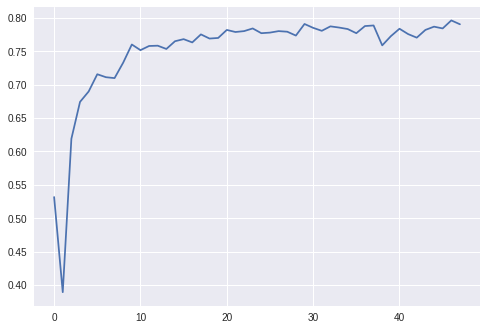

In [37]:
plt.plot(eval_list)

やはり今回の問題で7ユニット以下では表現力不足になる。